In [20]:
DATASET_DIR = ''
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K

environment='L'


In [21]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [13]:
'''
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

print((X.groupby("domain1_score").size()))
'''

'\nX = pd.read_csv(os.path.join(DATASET_DIR, \'training_set_rel3.tsv\'), sep=\'\t\', encoding=\'ISO-8859-1\')\n#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])\nX = (X[(X["essay_set"] == 1)])\ny = X[\'domain1_score\']\nX = X.dropna(axis=1)\nX = X.drop(columns=[\'rater1_domain1\', \'rater2_domain1\'])\nos.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")\n\nprint((X.groupby("domain1_score").size()))\n'

In [14]:

'''
X = pd.read_csv(os.path.join(DATASET_DIR, 'essay_set1_merged.csv'), encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
print(X.columns)
#y = X[[ 'domain1_score', 'Content',
#       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
  
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])

X = X.dropna(axis=1)
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")
'''

'\nX = pd.read_csv(os.path.join(DATASET_DIR, \'essay_set1_merged.csv\'), encoding=\'ISO-8859-1\')\n#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])\nX = (X[(X["essay_set"] == 1)])\nprint(X.columns)\n#y = X[[ \'domain1_score\', \'Content\',\n#       \'Organization\', \'Word Choice\', \'Sentence Fluency\', \'Conventions\']]\ny_domain_score=X[[\'rater1_domain1\']]\ny_content=X[[\'Content\']]\ny_organization=X[[\'Organization\']]\ny_wordChoice=X[[\'Word Choice\']]\ny_sentenceFluency=X[[\'Sentence Fluency\']]\ny_conventions=X[[\'Conventions\']]\n  \n#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])\n\nX = X.dropna(axis=1)\nos.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")\n'

domain1_score
2.0       30
3.0        8
4.0      126
5.0       98
6.0      695
7.0      373
8.0     1339
9.0      388
10.0     360
11.0     115
12.0      51
dtype: int64


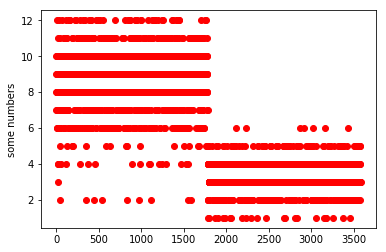

'\nprint((X.groupby("rater1_domain1").size()))\n\nprint(X.columns)\nX_1 =  X[(X[\'rater1_domain1\']==1) |( X[\'rater1_domain1\']==2)|( X[\'rater1_domain1\']==3)\n         |( X[\'rater1_domain1\']==6) ]\n\nX_4 = X[(X[\'rater1_domain1\']==4)]#[1:200]\nX_5 = X[(X[\'rater1_domain1\']==5)]#[1:200]\n\nX = pd.concat([X_1,X_4,X_5])\nprint((X.groupby("rater1_domain1").size()))\n\ny = X[\'rater1_domain1\']\n\nX.to_csv("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source/xxx.csv",index=False)\n'

In [33]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'),  encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)|(X["essay_set"] == 2)])
#X = (X[(X["essay_set"] == 1)])
y = X['domain1_score_org']
#X = X.dropna(axis=1)
#X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
#X[(X["essay_set"] == 1) | (X["essay_set"] == 2)]

#print("x shape"+ str(X.shape))
#print("y shape"+ str(y))
print((X.groupby("domain1_score").size()))

import matplotlib.pyplot as plt
plt.plot(y, 'ro')
plt.ylabel('some numbers')
plt.show()

y1 = y.to_frame()
#print(y.columns)
#print(type(y))

#X =X.to_frame()
'''
print((X.groupby("rater1_domain1").size()))

print(X.columns)
X_1 =  X[(X['rater1_domain1']==1) |( X['rater1_domain1']==2)|( X['rater1_domain1']==3)
         |( X['rater1_domain1']==6) ]

X_4 = X[(X['rater1_domain1']==4)]#[1:200]
X_5 = X[(X['rater1_domain1']==5)]#[1:200]

X = pd.concat([X_1,X_4,X_5])
print((X.groupby("rater1_domain1").size()))

y = X['rater1_domain1']

X.to_csv("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source/xxx.csv",index=False)
'''

Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [34]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [8]:

'''
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD,Adam
opt = SGD(lr=0.01)
def get_model():
    """Define the model.""" 
    inputs = Input(shape=(1, 300))
    extract = LSTM(300,  return_sequences=True)(inputs)
    class11 = LSTM(64, recurrent_dropout=0.4)(extract)
    output1 = Dense(7, activation='sigmoid')(class11)
  
    output2 = Dense(7, activation='sigmoid')(class11)
    output3 = Dense(7, activation='sigmoid')(class11)
    output4 = Dense(7, activation='sigmoid')(class11)
    output5 = Dense(7, activation='sigmoid')(class11)
    output6 = Dense(7, activation='sigmoid')(class11)
  
    model = Model(inputs=inputs,outputs=[output1])
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model
'''

'\nfrom keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten\nfrom keras.models import Sequential, load_model, model_from_config\nimport keras.backend as K\nfrom keras.utils.np_utils import to_categorical\nfrom keras.layers import Input\nfrom keras.models import Model\nfrom keras.optimizers import SGD,Adam\nopt = SGD(lr=0.01)\ndef get_model():\n    """Define the model.""" \n    inputs = Input(shape=(1, 300))\n    extract = LSTM(300,  return_sequences=True)(inputs)\n    class11 = LSTM(64, recurrent_dropout=0.4)(extract)\n    output1 = Dense(7, activation=\'sigmoid\')(class11)\n  \n    output2 = Dense(7, activation=\'sigmoid\')(class11)\n    output3 = Dense(7, activation=\'sigmoid\')(class11)\n    output4 = Dense(7, activation=\'sigmoid\')(class11)\n    output5 = Dense(7, activation=\'sigmoid\')(class11)\n    output6 = Dense(7, activation=\'sigmoid\')(class11)\n  \n    model = Model(inputs=inputs,outputs=[output1])\n    opt = Adam(lr=0.001)\n    model.compile(loss=\'binar

In [28]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300,  input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.

In [35]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

'''
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
'''

K.clear_session()

results = []
y_pred_list = []

count = 1
print(X.shape)
train_essays = X['essay']

sentences = []
for essay in train_essays:
        sentences += essay_to_sentences(essay, remove_stopwords = True)
     
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays = []

# Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

trainDataVecs = np.array(trainDataVecs)
#trainDataVecs= trainDataVecs[400:]
#print("trainDataVecs"+str(trainDataVecs.shape))
#testDataVecs = trainDataVecs[1:400]
trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
#testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

#validsiz=200
'''
y_domain_score_c = to_categorical(y)

y_content_c = to_categorical(y_content)
y_organization_c = to_categorical(y_organization)
y_wordChoice_c = to_categorical(y_wordChoice)
y_sentenceFluency_c = to_categorical(y_sentenceFluency)
y_conventions_c = to_categorical(y_conventions)

print(y_domain_score_c)
'''
print(y[1:10])
#y_c = to_categorical(y)
lstm_model = get_model()
'''
history = lstm_model.fit(trainDataVecs,
                         y=[y_domain_score_c,y_content_c,y_organization_c,y_wordChoice_c
                             ,y_sentenceFluency_c,y_conventions_c] ,validation_split=0.2
                         ,batch_size=64, epochs=50)
'''
y= y[400:]
print("y shape"+ str(y.shape))
y_test = y[1:400]
print("y_test shape"+ str(y_test.shape))

history = lstm_model.fit(trainDataVecs,
                         y ,validation_split=0.2
                         ,batch_size=64, epochs=50)

y_pred = lstm_model.predict(testDataVecs)


print(history.history.keys())
if count == 1:
     lstm_model.save('final_lstm.h5')



y_pred = np.around(y_pred)

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))

'''
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.subplot(222)
valacc = history.history['val_dense_1_acc']
acc = history.history['dense_1_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for domain score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''
'''
plt.subplot(223)
valacc = history.history['val_dense_2_acc']
acc = history.history['dense_2_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(224)
valacc = history.history['val_dense_3_acc']
acc = history.history['dense_3_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Organization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(234)
valacc = history.history['val_dense_4_acc']
acc = history.history['dense_4_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Word Choice')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(244)
valacc = history.history['val_dense_5_acc']
acc = history.history['dense_5_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Sentence Fluency')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(344)
valacc = history.history['val_dense_6_acc']
acc = history.history['dense_6_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Conventions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#break
count += 1

'''

(3583, 29)


Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs(3183, 300)
1     9.0
2     7.0
3    10.0
4     8.0
5     8.0
6    10.0
7    10.0
8     9.0
9     9.0
Name: domain1_score_org, dtype: float64


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
y shape(3183,)
y_test shape(399,)


Train on 2546 samples, validate on 637 samples
Epoch 1/50


  64/2546 [..............................] - ETA: 1:08 - loss: 46.7353 - mean_absolute_error: 6.2491

 192/2546 [=>............................] - ETA: 22s - loss: 44.0763 - mean_absolute_error: 6.0005 

 320/2546 [==>...........................] - ETA: 13s - loss: 44.8172 - mean_absolute_error: 6.0795

 448/2546 [====>.........................] - ETA: 9s - loss: 42.9270 - mean_absolute_error: 5.9305 

 576/2546 [=====>........................] - ETA: 6s - loss: 42.6940 - mean_absolute_error: 5.9155

 704/2546 [=======>......................] - ETA: 5s - loss: 41.5235 - mean_absolute_error: 5.8242

 768/2546 [========>.....................] - ETA: 4s - loss: 41.0954 - mean_absolute_error: 5.7895

 896/2546 [=========>....................] - ETA: 4s - loss: 39.0505 - mean_absolute_error: 5.6028

1024/2546 [===========>..................] - ETA: 3s - loss: 37.4693 - mean_absolute_error: 5.4608

1152/2546 [============>.................] - ETA: 2s - loss: 36.0314 - mean_absolute_error: 5.3282

1280/2546 [==============>...............] - ETA: 2s - loss: 34.4881 - mean_absolute_error: 5.1756

1408/2546 [===============>..............] - ETA: 1s - loss: 32.8012 - mean_absolute_error: 5.0017

1536/2546 [=================>............] - ETA: 1s - loss: 31.0649 - mean_absolute_error: 4.8097

1664/2546 [==================>...........] - ETA: 1s - loss: 29.5404 - mean_absolute_error: 4.6417

1792/2546 [====================>.........] - ETA: 1s - loss: 28.0602 - mean_absolute_error: 4.4754

1920/2546 [=====================>........] - ETA: 0s - loss: 26.6814 - mean_absolute_error: 4.3186

2048/2546 [=======================>......] - ETA: 0s - loss: 25.4369 - mean_absolute_error: 4.1757

2176/2546 [========================>.....] - ETA: 0s - loss: 24.2303 - mean_absolute_error: 4.0309

2304/2546 [==========================>...] - ETA: 0s - loss: 23.1568 - mean_absolute_error: 3.9001

2432/2546 [===========================>..] - ETA: 0s - loss: 22.1869 - mean_absolute_error: 3.7844

2546/2546 [==============================] - 3s 1ms/step - loss: 21.3795 - mean_absolute_error: 3.6851 - val_loss: 2.1274 - val_mean_absolute_error: 1.1296


Epoch 2/50
  64/2546 [..............................] - ETA: 2s - loss: 5.0293 - mean_absolute_error: 1.6556

 192/2546 [=>............................] - ETA: 1s - loss: 3.9353 - mean_absolute_error: 1.4650

 320/2546 [==>...........................] - ETA: 1s - loss: 3.7365 - mean_absolute_error: 1.4444

 448/2546 [====>.........................] - ETA: 1s - loss: 3.5814 - mean_absolute_error: 1.4189

 576/2546 [=====>........................] - ETA: 1s - loss: 3.5701 - mean_absolute_error: 1.4209

 704/2546 [=======>......................] - ETA: 0s - loss: 3.4904 - mean_absolute_error: 1.3993

 832/2546 [========>.....................] - ETA: 0s - loss: 3.5071 - mean_absolute_error: 1.4088

 960/2546 [==========>...................] - ETA: 0s - loss: 3.3277 - mean_absolute_error: 1.3774

1088/2546 [===========>..................] - ETA: 0s - loss: 3.2927 - mean_absolute_error: 1.3720

1216/2546 [=============>................] - ETA: 0s - loss: 3.2525 - mean_absolute_error: 1.3649

1344/2546 [==============>...............] - ETA: 0s - loss: 3.1842 - mean_absolute_error: 1.3548

1472/2546 [================>.............] - ETA: 0s - loss: 3.1726 - mean_absolute_error: 1.3549

1600/2546 [=================>............] - ETA: 0s - loss: 3.1206 - mean_absolute_error: 1.3444

1728/2546 [===================>..........] - ETA: 0s - loss: 3.1554 - mean_absolute_error: 1.3493

1856/2546 [====================>.........] - ETA: 0s - loss: 3.0979 - mean_absolute_error: 1.3386

1984/2546 [======================>.......] - ETA: 0s - loss: 3.0910 - mean_absolute_error: 1.3382

2112/2546 [=======================>......] - ETA: 0s - loss: 3.0468 - mean_absolute_error: 1.3304

2240/2546 [=========================>....] - ETA: 0s - loss: 3.0415 - mean_absolute_error: 1.3323

2368/2546 [==========================>...] - ETA: 0s - loss: 3.0058 - mean_absolute_error: 1.3228

2496/2546 [============================>.] - ETA: 0s - loss: 2.9741 - mean_absolute_error: 1.3168

2546/2546 [==============================] - 1s 528us/step - loss: 2.9884 - mean_absolute_error: 1.3207 - val_loss: 1.8136 - val_mean_absolute_error: 1.0326


Epoch 3/50
  64/2546 [..............................] - ETA: 1s - loss: 3.2520 - mean_absolute_error: 1.4276

 192/2546 [=>............................] - ETA: 1s - loss: 2.8966 - mean_absolute_error: 1.3198

 320/2546 [==>...........................] - ETA: 1s - loss: 2.7298 - mean_absolute_error: 1.3027

 448/2546 [====>.........................] - ETA: 1s - loss: 2.8128 - mean_absolute_error: 1.3045

 576/2546 [=====>........................] - ETA: 0s - loss: 2.7665 - mean_absolute_error: 1.3034

 704/2546 [=======>......................] - ETA: 0s - loss: 2.7196 - mean_absolute_error: 1.2916

 832/2546 [========>.....................] - ETA: 0s - loss: 2.6276 - mean_absolute_error: 1.2720

 960/2546 [==========>...................] - ETA: 0s - loss: 2.6197 - mean_absolute_error: 1.2676

1088/2546 [===========>..................] - ETA: 0s - loss: 2.5803 - mean_absolute_error: 1.2545

1216/2546 [=============>................] - ETA: 0s - loss: 2.5383 - mean_absolute_error: 1.2413

1344/2546 [==============>...............] - ETA: 0s - loss: 2.5111 - mean_absolute_error: 1.2308

1472/2546 [================>.............] - ETA: 0s - loss: 2.4563 - mean_absolute_error: 1.2133

1600/2546 [=================>............] - ETA: 0s - loss: 2.4981 - mean_absolute_error: 1.2126

1728/2546 [===================>..........] - ETA: 0s - loss: 2.4301 - mean_absolute_error: 1.1947

1856/2546 [====================>.........] - ETA: 0s - loss: 2.4757 - mean_absolute_error: 1.2121

1984/2546 [======================>.......] - ETA: 0s - loss: 2.5357 - mean_absolute_error: 1.2168

2112/2546 [=======================>......] - ETA: 0s - loss: 2.5394 - mean_absolute_error: 1.2140

2240/2546 [=========================>....] - ETA: 0s - loss: 2.5673 - mean_absolute_error: 1.2224

2368/2546 [==========================>...] - ETA: 0s - loss: 2.5671 - mean_absolute_error: 1.2227

2496/2546 [============================>.] - ETA: 0s - loss: 2.5444 - mean_absolute_error: 1.2197

2546/2546 [==============================] - 1s 514us/step - loss: 2.5364 - mean_absolute_error: 1.2157 - val_loss: 1.2457 - val_mean_absolute_error: 0.8603


Epoch 4/50
  64/2546 [..............................] - ETA: 1s - loss: 2.1783 - mean_absolute_error: 1.1766

 192/2546 [=>............................] - ETA: 1s - loss: 2.1797 - mean_absolute_error: 1.1498

 320/2546 [==>...........................] - ETA: 1s - loss: 2.3804 - mean_absolute_error: 1.2162

 448/2546 [====>.........................] - ETA: 1s - loss: 2.2829 - mean_absolute_error: 1.1946

 576/2546 [=====>........................] - ETA: 0s - loss: 2.2690 - mean_absolute_error: 1.1791

 704/2546 [=======>......................] - ETA: 0s - loss: 2.2913 - mean_absolute_error: 1.1816

 832/2546 [========>.....................] - ETA: 0s - loss: 2.4026 - mean_absolute_error: 1.2075

 960/2546 [==========>...................] - ETA: 0s - loss: 2.4733 - mean_absolute_error: 1.2193

1088/2546 [===========>..................] - ETA: 0s - loss: 2.4514 - mean_absolute_error: 1.2079

1216/2546 [=============>................] - ETA: 0s - loss: 2.4303 - mean_absolute_error: 1.2030

1344/2546 [==============>...............] - ETA: 0s - loss: 2.4370 - mean_absolute_error: 1.2041

1472/2546 [================>.............] - ETA: 0s - loss: 2.4510 - mean_absolute_error: 1.2080

1600/2546 [=================>............] - ETA: 0s - loss: 2.4423 - mean_absolute_error: 1.2081

1728/2546 [===================>..........] - ETA: 0s - loss: 2.4386 - mean_absolute_error: 1.2083

1856/2546 [====================>.........] - ETA: 0s - loss: 2.3819 - mean_absolute_error: 1.1901

1984/2546 [======================>.......] - ETA: 0s - loss: 2.3911 - mean_absolute_error: 1.1951

2112/2546 [=======================>......] - ETA: 0s - loss: 2.4126 - mean_absolute_error: 1.1990

2240/2546 [=========================>....] - ETA: 0s - loss: 2.4492 - mean_absolute_error: 1.2053

2368/2546 [==========================>...] - ETA: 0s - loss: 2.4211 - mean_absolute_error: 1.2001

2496/2546 [============================>.] - ETA: 0s - loss: 2.3998 - mean_absolute_error: 1.1927

2546/2546 [==============================] - 1s 527us/step - loss: 2.4079 - mean_absolute_error: 1.1936 - val_loss: 1.1201 - val_mean_absolute_error: 0.8079


Epoch 5/50
  64/2546 [..............................] - ETA: 1s - loss: 3.5106 - mean_absolute_error: 1.4169

 192/2546 [=>............................] - ETA: 1s - loss: 2.3258 - mean_absolute_error: 1.1218

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1748 - mean_absolute_error: 1.0916

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0929 - mean_absolute_error: 1.0824

 576/2546 [=====>........................] - ETA: 1s - loss: 2.1691 - mean_absolute_error: 1.1170

 704/2546 [=======>......................] - ETA: 0s - loss: 2.1726 - mean_absolute_error: 1.1319

 832/2546 [========>.....................] - ETA: 0s - loss: 2.1235 - mean_absolute_error: 1.1242

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1838 - mean_absolute_error: 1.1441

1088/2546 [===========>..................] - ETA: 0s - loss: 2.2292 - mean_absolute_error: 1.1574

1216/2546 [=============>................] - ETA: 0s - loss: 2.2500 - mean_absolute_error: 1.1639

1344/2546 [==============>...............] - ETA: 0s - loss: 2.2265 - mean_absolute_error: 1.1597

1472/2546 [================>.............] - ETA: 0s - loss: 2.2198 - mean_absolute_error: 1.1577

1600/2546 [=================>............] - ETA: 0s - loss: 2.2391 - mean_absolute_error: 1.1654

1728/2546 [===================>..........] - ETA: 0s - loss: 2.2962 - mean_absolute_error: 1.1757

1856/2546 [====================>.........] - ETA: 0s - loss: 2.3158 - mean_absolute_error: 1.1792

1984/2546 [======================>.......] - ETA: 0s - loss: 2.2996 - mean_absolute_error: 1.1734

2112/2546 [=======================>......] - ETA: 0s - loss: 2.3101 - mean_absolute_error: 1.1790

2240/2546 [=========================>....] - ETA: 0s - loss: 2.2882 - mean_absolute_error: 1.1749

2304/2546 [==========================>...] - ETA: 0s - loss: 2.3072 - mean_absolute_error: 1.1754

2432/2546 [===========================>..] - ETA: 0s - loss: 2.3040 - mean_absolute_error: 1.1749

2546/2546 [==============================] - 1s 549us/step - loss: 2.3209 - mean_absolute_error: 1.1811 - val_loss: 1.0391 - val_mean_absolute_error: 0.8009


Epoch 6/50


  64/2546 [..............................] - ETA: 1s - loss: 2.1770 - mean_absolute_error: 1.1459

 192/2546 [=>............................] - ETA: 1s - loss: 2.2455 - mean_absolute_error: 1.1409

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1883 - mean_absolute_error: 1.1401

 448/2546 [====>.........................] - ETA: 1s - loss: 2.1175 - mean_absolute_error: 1.1223

 576/2546 [=====>........................] - ETA: 1s - loss: 2.2911 - mean_absolute_error: 1.1597

 704/2546 [=======>......................] - ETA: 0s - loss: 2.3696 - mean_absolute_error: 1.1731

 832/2546 [========>.....................] - ETA: 0s - loss: 2.4501 - mean_absolute_error: 1.1828

 960/2546 [==========>...................] - ETA: 0s - loss: 2.4404 - mean_absolute_error: 1.1748

1088/2546 [===========>..................] - ETA: 0s - loss: 2.4452 - mean_absolute_error: 1.1815

1216/2546 [=============>................] - ETA: 0s - loss: 2.4786 - mean_absolute_error: 1.1947

1344/2546 [==============>...............] - ETA: 0s - loss: 2.4454 - mean_absolute_error: 1.1876

1472/2546 [================>.............] - ETA: 0s - loss: 2.4508 - mean_absolute_error: 1.1885

1600/2546 [=================>............] - ETA: 0s - loss: 2.4491 - mean_absolute_error: 1.1875

1664/2546 [==================>...........] - ETA: 0s - loss: 2.4479 - mean_absolute_error: 1.1883

1792/2546 [====================>.........] - ETA: 0s - loss: 2.3805 - mean_absolute_error: 1.1727

1920/2546 [=====================>........] - ETA: 0s - loss: 2.4207 - mean_absolute_error: 1.1830

2048/2546 [=======================>......] - ETA: 0s - loss: 2.4166 - mean_absolute_error: 1.1865

2112/2546 [=======================>......] - ETA: 0s - loss: 2.4021 - mean_absolute_error: 1.1843

2240/2546 [=========================>....] - ETA: 0s - loss: 2.3905 - mean_absolute_error: 1.1838

2368/2546 [==========================>...] - ETA: 0s - loss: 2.4211 - mean_absolute_error: 1.1914

2496/2546 [============================>.] - ETA: 0s - loss: 2.4006 - mean_absolute_error: 1.1878

2546/2546 [==============================] - 1s 546us/step - loss: 2.3916 - mean_absolute_error: 1.1849 - val_loss: 1.0591 - val_mean_absolute_error: 0.7893


Epoch 7/50


  64/2546 [..............................] - ETA: 1s - loss: 3.2130 - mean_absolute_error: 1.3810

 192/2546 [=>............................] - ETA: 1s - loss: 3.2499 - mean_absolute_error: 1.3485

 320/2546 [==>...........................] - ETA: 1s - loss: 2.7474 - mean_absolute_error: 1.2531

 448/2546 [====>.........................] - ETA: 1s - loss: 2.4622 - mean_absolute_error: 1.1969

 576/2546 [=====>........................] - ETA: 0s - loss: 2.3152 - mean_absolute_error: 1.1565

 704/2546 [=======>......................] - ETA: 0s - loss: 2.2242 - mean_absolute_error: 1.1380

 832/2546 [========>.....................] - ETA: 0s - loss: 2.2251 - mean_absolute_error: 1.1401

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1923 - mean_absolute_error: 1.1272

1088/2546 [===========>..................] - ETA: 0s - loss: 2.2543 - mean_absolute_error: 1.1425

1216/2546 [=============>................] - ETA: 0s - loss: 2.2599 - mean_absolute_error: 1.1499

1344/2546 [==============>...............] - ETA: 0s - loss: 2.3250 - mean_absolute_error: 1.1613

1472/2546 [================>.............] - ETA: 0s - loss: 2.4037 - mean_absolute_error: 1.1711

1600/2546 [=================>............] - ETA: 0s - loss: 2.4047 - mean_absolute_error: 1.1749

1728/2546 [===================>..........] - ETA: 0s - loss: 2.4050 - mean_absolute_error: 1.1767

1856/2546 [====================>.........] - ETA: 0s - loss: 2.3975 - mean_absolute_error: 1.1783

1984/2546 [======================>.......] - ETA: 0s - loss: 2.4196 - mean_absolute_error: 1.1838

2112/2546 [=======================>......] - ETA: 0s - loss: 2.3829 - mean_absolute_error: 1.1780

2240/2546 [=========================>....] - ETA: 0s - loss: 2.3686 - mean_absolute_error: 1.1736

2368/2546 [==========================>...] - ETA: 0s - loss: 2.3548 - mean_absolute_error: 1.1695

2496/2546 [============================>.] - ETA: 0s - loss: 2.3519 - mean_absolute_error: 1.1694

2546/2546 [==============================] - 1s 529us/step - loss: 2.3413 - mean_absolute_error: 1.1667 - val_loss: 1.2413 - val_mean_absolute_error: 0.8426


Epoch 8/50


  64/2546 [..............................] - ETA: 2s - loss: 2.3822 - mean_absolute_error: 1.2059

 128/2546 [>.............................] - ETA: 1s - loss: 2.0177 - mean_absolute_error: 1.1211

 256/2546 [==>...........................] - ETA: 1s - loss: 2.2025 - mean_absolute_error: 1.1479

 384/2546 [===>..........................] - ETA: 1s - loss: 2.0867 - mean_absolute_error: 1.1192

 512/2546 [=====>........................] - ETA: 1s - loss: 2.0079 - mean_absolute_error: 1.0802

 640/2546 [======>.......................] - ETA: 1s - loss: 1.9980 - mean_absolute_error: 1.0813

 768/2546 [========>.....................] - ETA: 0s - loss: 2.1114 - mean_absolute_error: 1.1042

 896/2546 [=========>....................] - ETA: 0s - loss: 2.0915 - mean_absolute_error: 1.0935

1024/2546 [===========>..................] - ETA: 0s - loss: 2.2021 - mean_absolute_error: 1.1140

1152/2546 [============>.................] - ETA: 0s - loss: 2.1742 - mean_absolute_error: 1.1052

1280/2546 [==============>...............] - ETA: 0s - loss: 2.1475 - mean_absolute_error: 1.1028

1408/2546 [===============>..............] - ETA: 0s - loss: 2.2046 - mean_absolute_error: 1.1230

1536/2546 [=================>............] - ETA: 0s - loss: 2.2374 - mean_absolute_error: 1.1338

1664/2546 [==================>...........] - ETA: 0s - loss: 2.2377 - mean_absolute_error: 1.1328

1792/2546 [====================>.........] - ETA: 0s - loss: 2.2651 - mean_absolute_error: 1.1365

1920/2546 [=====================>........] - ETA: 0s - loss: 2.2623 - mean_absolute_error: 1.1371

2048/2546 [=======================>......] - ETA: 0s - loss: 2.2467 - mean_absolute_error: 1.1311

2176/2546 [========================>.....] - ETA: 0s - loss: 2.2328 - mean_absolute_error: 1.1271

2304/2546 [==========================>...] - ETA: 0s - loss: 2.2369 - mean_absolute_error: 1.1305

2432/2546 [===========================>..] - ETA: 0s - loss: 2.2458 - mean_absolute_error: 1.1348

2546/2546 [==============================] - 1s 545us/step - loss: 2.2727 - mean_absolute_error: 1.1402 - val_loss: 1.2478 - val_mean_absolute_error: 0.8419


Epoch 9/50


  64/2546 [..............................] - ETA: 1s - loss: 2.0022 - mean_absolute_error: 1.1417

 192/2546 [=>............................] - ETA: 1s - loss: 2.0678 - mean_absolute_error: 1.1427

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9584 - mean_absolute_error: 1.0998

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0937 - mean_absolute_error: 1.1147

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0270 - mean_absolute_error: 1.0917

 704/2546 [=======>......................] - ETA: 0s - loss: 1.9937 - mean_absolute_error: 1.0884

 832/2546 [========>.....................] - ETA: 0s - loss: 1.9891 - mean_absolute_error: 1.0820

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0506 - mean_absolute_error: 1.0988

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0454 - mean_absolute_error: 1.0938

1216/2546 [=============>................] - ETA: 0s - loss: 2.0439 - mean_absolute_error: 1.0949

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0432 - mean_absolute_error: 1.0978

1472/2546 [================>.............] - ETA: 0s - loss: 2.0348 - mean_absolute_error: 1.0904

1600/2546 [=================>............] - ETA: 0s - loss: 2.0928 - mean_absolute_error: 1.1015

1728/2546 [===================>..........] - ETA: 0s - loss: 2.1764 - mean_absolute_error: 1.1184

1856/2546 [====================>.........] - ETA: 0s - loss: 2.2025 - mean_absolute_error: 1.1266

1984/2546 [======================>.......] - ETA: 0s - loss: 2.2009 - mean_absolute_error: 1.1263

2112/2546 [=======================>......] - ETA: 0s - loss: 2.1921 - mean_absolute_error: 1.1228

2240/2546 [=========================>....] - ETA: 0s - loss: 2.2015 - mean_absolute_error: 1.1289

2368/2546 [==========================>...] - ETA: 0s - loss: 2.1871 - mean_absolute_error: 1.1280

2496/2546 [============================>.] - ETA: 0s - loss: 2.2137 - mean_absolute_error: 1.1350

2546/2546 [==============================] - 1s 526us/step - loss: 2.2115 - mean_absolute_error: 1.1338 - val_loss: 1.0217 - val_mean_absolute_error: 0.7778


Epoch 10/50
  64/2546 [..............................] - ETA: 1s - loss: 2.1834 - mean_absolute_error: 1.1360

 192/2546 [=>............................] - ETA: 1s - loss: 2.2018 - mean_absolute_error: 1.1044

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1796 - mean_absolute_error: 1.1354

 448/2546 [====>.........................] - ETA: 1s - loss: 2.2692 - mean_absolute_error: 1.1463

 576/2546 [=====>........................] - ETA: 0s - loss: 2.1981 - mean_absolute_error: 1.1301

 704/2546 [=======>......................] - ETA: 0s - loss: 2.2055 - mean_absolute_error: 1.1348

 832/2546 [========>.....................] - ETA: 0s - loss: 2.2554 - mean_absolute_error: 1.1502

 960/2546 [==========>...................] - ETA: 0s - loss: 2.2476 - mean_absolute_error: 1.1530

1088/2546 [===========>..................] - ETA: 0s - loss: 2.2628 - mean_absolute_error: 1.1540

1216/2546 [=============>................] - ETA: 0s - loss: 2.2540 - mean_absolute_error: 1.1482

1344/2546 [==============>...............] - ETA: 0s - loss: 2.2789 - mean_absolute_error: 1.1582

1472/2546 [================>.............] - ETA: 0s - loss: 2.3405 - mean_absolute_error: 1.1663

1600/2546 [=================>............] - ETA: 0s - loss: 2.3283 - mean_absolute_error: 1.1569

1728/2546 [===================>..........] - ETA: 0s - loss: 2.3029 - mean_absolute_error: 1.1526

1856/2546 [====================>.........] - ETA: 0s - loss: 2.2700 - mean_absolute_error: 1.1454

1984/2546 [======================>.......] - ETA: 0s - loss: 2.2443 - mean_absolute_error: 1.1408

2112/2546 [=======================>......] - ETA: 0s - loss: 2.2187 - mean_absolute_error: 1.1357

2240/2546 [=========================>....] - ETA: 0s - loss: 2.2145 - mean_absolute_error: 1.1371

2368/2546 [==========================>...] - ETA: 0s - loss: 2.1974 - mean_absolute_error: 1.1340

2432/2546 [===========================>..] - ETA: 0s - loss: 2.1925 - mean_absolute_error: 1.1332

2546/2546 [==============================] - 1s 519us/step - loss: 2.1885 - mean_absolute_error: 1.1298 - val_loss: 0.9432 - val_mean_absolute_error: 0.7546


Epoch 11/50
  64/2546 [..............................] - ETA: 1s - loss: 2.6272 - mean_absolute_error: 1.1853

 128/2546 [>.............................] - ETA: 1s - loss: 2.4629 - mean_absolute_error: 1.1342

 256/2546 [==>...........................] - ETA: 1s - loss: 2.2402 - mean_absolute_error: 1.0826

 384/2546 [===>..........................] - ETA: 1s - loss: 2.2228 - mean_absolute_error: 1.1081

 512/2546 [=====>........................] - ETA: 1s - loss: 2.2593 - mean_absolute_error: 1.1298

 640/2546 [======>.......................] - ETA: 1s - loss: 2.2798 - mean_absolute_error: 1.1343

 768/2546 [========>.....................] - ETA: 0s - loss: 2.2386 - mean_absolute_error: 1.1317

 896/2546 [=========>....................] - ETA: 0s - loss: 2.2134 - mean_absolute_error: 1.1279

1024/2546 [===========>..................] - ETA: 0s - loss: 2.1832 - mean_absolute_error: 1.1243

1152/2546 [============>.................] - ETA: 0s - loss: 2.2286 - mean_absolute_error: 1.1278

1280/2546 [==============>...............] - ETA: 0s - loss: 2.3943 - mean_absolute_error: 1.1596

1408/2546 [===============>..............] - ETA: 0s - loss: 2.3566 - mean_absolute_error: 1.1539

1536/2546 [=================>............] - ETA: 0s - loss: 2.3094 - mean_absolute_error: 1.1414

1664/2546 [==================>...........] - ETA: 0s - loss: 2.3229 - mean_absolute_error: 1.1503

1792/2546 [====================>.........] - ETA: 0s - loss: 2.3361 - mean_absolute_error: 1.1506

1920/2546 [=====================>........] - ETA: 0s - loss: 2.3620 - mean_absolute_error: 1.1547

2048/2546 [=======================>......] - ETA: 0s - loss: 2.3500 - mean_absolute_error: 1.1523

2176/2546 [========================>.....] - ETA: 0s - loss: 2.3219 - mean_absolute_error: 1.1487

2240/2546 [=========================>....] - ETA: 0s - loss: 2.3217 - mean_absolute_error: 1.1516

2304/2546 [==========================>...] - ETA: 0s - loss: 2.3127 - mean_absolute_error: 1.1509

2432/2546 [===========================>..] - ETA: 0s - loss: 2.2945 - mean_absolute_error: 1.1476

2546/2546 [==============================] - 1s 560us/step - loss: 2.2915 - mean_absolute_error: 1.1449 - val_loss: 0.9533 - val_mean_absolute_error: 0.7517


Epoch 12/50
  64/2546 [..............................] - ETA: 1s - loss: 2.1679 - mean_absolute_error: 1.1268

 192/2546 [=>............................] - ETA: 1s - loss: 2.3534 - mean_absolute_error: 1.1423

 320/2546 [==>...........................] - ETA: 1s - loss: 2.3132 - mean_absolute_error: 1.1284

 448/2546 [====>.........................] - ETA: 1s - loss: 2.2505 - mean_absolute_error: 1.1145

 576/2546 [=====>........................] - ETA: 1s - loss: 2.2747 - mean_absolute_error: 1.1315

 704/2546 [=======>......................] - ETA: 0s - loss: 2.2290 - mean_absolute_error: 1.1205

 832/2546 [========>.....................] - ETA: 0s - loss: 2.1920 - mean_absolute_error: 1.1111

 960/2546 [==========>...................] - ETA: 0s - loss: 2.2639 - mean_absolute_error: 1.1183

1088/2546 [===========>..................] - ETA: 0s - loss: 2.2289 - mean_absolute_error: 1.1090

1216/2546 [=============>................] - ETA: 0s - loss: 2.2002 - mean_absolute_error: 1.1118

1344/2546 [==============>...............] - ETA: 0s - loss: 2.2458 - mean_absolute_error: 1.1238

1472/2546 [================>.............] - ETA: 0s - loss: 2.2315 - mean_absolute_error: 1.1251

1600/2546 [=================>............] - ETA: 0s - loss: 2.2468 - mean_absolute_error: 1.1284

1728/2546 [===================>..........] - ETA: 0s - loss: 2.2540 - mean_absolute_error: 1.1340

1856/2546 [====================>.........] - ETA: 0s - loss: 2.2260 - mean_absolute_error: 1.1288

1984/2546 [======================>.......] - ETA: 0s - loss: 2.2248 - mean_absolute_error: 1.1292

2112/2546 [=======================>......] - ETA: 0s - loss: 2.2262 - mean_absolute_error: 1.1261

2240/2546 [=========================>....] - ETA: 0s - loss: 2.2152 - mean_absolute_error: 1.1235

2368/2546 [==========================>...] - ETA: 0s - loss: 2.2406 - mean_absolute_error: 1.1353

2496/2546 [============================>.] - ETA: 0s - loss: 2.2077 - mean_absolute_error: 1.1281

2546/2546 [==============================] - 1s 516us/step - loss: 2.1976 - mean_absolute_error: 1.1266 - val_loss: 0.9274 - val_mean_absolute_error: 0.7594


Epoch 13/50


  64/2546 [..............................] - ETA: 1s - loss: 2.2820 - mean_absolute_error: 1.1798

 192/2546 [=>............................] - ETA: 1s - loss: 1.9755 - mean_absolute_error: 1.1038

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9281 - mean_absolute_error: 1.0736

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0226 - mean_absolute_error: 1.0806

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0238 - mean_absolute_error: 1.0703

 640/2546 [======>.......................] - ETA: 1s - loss: 2.0738 - mean_absolute_error: 1.0820

 768/2546 [========>.....................] - ETA: 0s - loss: 2.0063 - mean_absolute_error: 1.0697

 896/2546 [=========>....................] - ETA: 0s - loss: 2.0157 - mean_absolute_error: 1.0783

1024/2546 [===========>..................] - ETA: 0s - loss: 2.1052 - mean_absolute_error: 1.0974

1152/2546 [============>.................] - ETA: 0s - loss: 2.0988 - mean_absolute_error: 1.1040

1280/2546 [==============>...............] - ETA: 0s - loss: 2.1484 - mean_absolute_error: 1.1066

1408/2546 [===============>..............] - ETA: 0s - loss: 2.1567 - mean_absolute_error: 1.1092

1536/2546 [=================>............] - ETA: 0s - loss: 2.1621 - mean_absolute_error: 1.1109

1664/2546 [==================>...........] - ETA: 0s - loss: 2.2534 - mean_absolute_error: 1.1292

1792/2546 [====================>.........] - ETA: 0s - loss: 2.2721 - mean_absolute_error: 1.1315

1920/2546 [=====================>........] - ETA: 0s - loss: 2.2734 - mean_absolute_error: 1.1353

2048/2546 [=======================>......] - ETA: 0s - loss: 2.2445 - mean_absolute_error: 1.1290

2176/2546 [========================>.....] - ETA: 0s - loss: 2.2876 - mean_absolute_error: 1.1383

2304/2546 [==========================>...] - ETA: 0s - loss: 2.2702 - mean_absolute_error: 1.1310

2432/2546 [===========================>..] - ETA: 0s - loss: 2.2434 - mean_absolute_error: 1.1264

2546/2546 [==============================] - 1s 537us/step - loss: 2.2172 - mean_absolute_error: 1.1213 - val_loss: 1.0940 - val_mean_absolute_error: 0.7854


Epoch 14/50


  64/2546 [..............................] - ETA: 1s - loss: 2.4615 - mean_absolute_error: 1.2114

 192/2546 [=>............................] - ETA: 1s - loss: 2.3701 - mean_absolute_error: 1.1822

 320/2546 [==>...........................] - ETA: 1s - loss: 2.3386 - mean_absolute_error: 1.1617

 448/2546 [====>.........................] - ETA: 1s - loss: 2.1954 - mean_absolute_error: 1.1168

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0210 - mean_absolute_error: 1.0756

 704/2546 [=======>......................] - ETA: 0s - loss: 1.9991 - mean_absolute_error: 1.0822

 832/2546 [========>.....................] - ETA: 0s - loss: 1.9935 - mean_absolute_error: 1.0849

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1021 - mean_absolute_error: 1.1023

1088/2546 [===========>..................] - ETA: 0s - loss: 2.1271 - mean_absolute_error: 1.1094

1216/2546 [=============>................] - ETA: 0s - loss: 2.1413 - mean_absolute_error: 1.1139

1344/2546 [==============>...............] - ETA: 0s - loss: 2.1179 - mean_absolute_error: 1.1136

1472/2546 [================>.............] - ETA: 0s - loss: 2.0904 - mean_absolute_error: 1.1049

1600/2546 [=================>............] - ETA: 0s - loss: 2.1631 - mean_absolute_error: 1.1179

1728/2546 [===================>..........] - ETA: 0s - loss: 2.1614 - mean_absolute_error: 1.1179

1856/2546 [====================>.........] - ETA: 0s - loss: 2.1743 - mean_absolute_error: 1.1222

1984/2546 [======================>.......] - ETA: 0s - loss: 2.1494 - mean_absolute_error: 1.1145

2112/2546 [=======================>......] - ETA: 0s - loss: 2.1555 - mean_absolute_error: 1.1180

2240/2546 [=========================>....] - ETA: 0s - loss: 2.1652 - mean_absolute_error: 1.1210

2368/2546 [==========================>...] - ETA: 0s - loss: 2.1777 - mean_absolute_error: 1.1265

2496/2546 [============================>.] - ETA: 0s - loss: 2.1836 - mean_absolute_error: 1.1264

2546/2546 [==============================] - 1s 526us/step - loss: 2.1933 - mean_absolute_error: 1.1280 - val_loss: 0.9294 - val_mean_absolute_error: 0.7456


Epoch 15/50
  64/2546 [..............................] - ETA: 1s - loss: 1.9990 - mean_absolute_error: 1.0771

 192/2546 [=>............................] - ETA: 1s - loss: 2.1982 - mean_absolute_error: 1.1154

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1635 - mean_absolute_error: 1.1181

 448/2546 [====>.........................] - ETA: 1s - loss: 2.1000 - mean_absolute_error: 1.1217

 576/2546 [=====>........................] - ETA: 1s - loss: 2.1528 - mean_absolute_error: 1.1325

 704/2546 [=======>......................] - ETA: 0s - loss: 2.1280 - mean_absolute_error: 1.1189

 832/2546 [========>.....................] - ETA: 0s - loss: 2.1587 - mean_absolute_error: 1.1239

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1233 - mean_absolute_error: 1.1130

1088/2546 [===========>..................] - ETA: 0s - loss: 2.1787 - mean_absolute_error: 1.1258

1216/2546 [=============>................] - ETA: 0s - loss: 2.1277 - mean_absolute_error: 1.1127

1344/2546 [==============>...............] - ETA: 0s - loss: 2.2050 - mean_absolute_error: 1.1284

1472/2546 [================>.............] - ETA: 0s - loss: 2.2195 - mean_absolute_error: 1.1371

1600/2546 [=================>............] - ETA: 0s - loss: 2.1914 - mean_absolute_error: 1.1349

1728/2546 [===================>..........] - ETA: 0s - loss: 2.2144 - mean_absolute_error: 1.1385

1856/2546 [====================>.........] - ETA: 0s - loss: 2.2131 - mean_absolute_error: 1.1313

1984/2546 [======================>.......] - ETA: 0s - loss: 2.1863 - mean_absolute_error: 1.1282

2112/2546 [=======================>......] - ETA: 0s - loss: 2.1973 - mean_absolute_error: 1.1324

2240/2546 [=========================>....] - ETA: 0s - loss: 2.1980 - mean_absolute_error: 1.1288

2368/2546 [==========================>...] - ETA: 0s - loss: 2.2232 - mean_absolute_error: 1.1351

2496/2546 [============================>.] - ETA: 0s - loss: 2.2121 - mean_absolute_error: 1.1321

2546/2546 [==============================] - 1s 539us/step - loss: 2.2269 - mean_absolute_error: 1.1345 - val_loss: 0.8774 - val_mean_absolute_error: 0.7426


Epoch 16/50
  64/2546 [..............................] - ETA: 1s - loss: 2.2544 - mean_absolute_error: 1.1837

 192/2546 [=>............................] - ETA: 1s - loss: 2.2217 - mean_absolute_error: 1.1505

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1993 - mean_absolute_error: 1.1402

 448/2546 [====>.........................] - ETA: 1s - loss: 2.2790 - mean_absolute_error: 1.1431

 576/2546 [=====>........................] - ETA: 1s - loss: 2.2355 - mean_absolute_error: 1.1327

 704/2546 [=======>......................] - ETA: 0s - loss: 2.2320 - mean_absolute_error: 1.1307

 832/2546 [========>.....................] - ETA: 0s - loss: 2.2042 - mean_absolute_error: 1.1357

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1618 - mean_absolute_error: 1.1183

1088/2546 [===========>..................] - ETA: 0s - loss: 2.1693 - mean_absolute_error: 1.1149

1216/2546 [=============>................] - ETA: 0s - loss: 2.1873 - mean_absolute_error: 1.1193

1344/2546 [==============>...............] - ETA: 0s - loss: 2.2524 - mean_absolute_error: 1.1411

1472/2546 [================>.............] - ETA: 0s - loss: 2.2626 - mean_absolute_error: 1.1442

1600/2546 [=================>............] - ETA: 0s - loss: 2.2864 - mean_absolute_error: 1.1493

1728/2546 [===================>..........] - ETA: 0s - loss: 2.2710 - mean_absolute_error: 1.1494

1856/2546 [====================>.........] - ETA: 0s - loss: 2.2173 - mean_absolute_error: 1.1374

1984/2546 [======================>.......] - ETA: 0s - loss: 2.1828 - mean_absolute_error: 1.1291

2112/2546 [=======================>......] - ETA: 0s - loss: 2.2024 - mean_absolute_error: 1.1328

2240/2546 [=========================>....] - ETA: 0s - loss: 2.2068 - mean_absolute_error: 1.1330

2368/2546 [==========================>...] - ETA: 0s - loss: 2.2085 - mean_absolute_error: 1.1322

2496/2546 [============================>.] - ETA: 0s - loss: 2.2067 - mean_absolute_error: 1.1295

2546/2546 [==============================] - 1s 526us/step - loss: 2.2075 - mean_absolute_error: 1.1298 - val_loss: 0.9507 - val_mean_absolute_error: 0.7329


Epoch 17/50
  64/2546 [..............................] - ETA: 1s - loss: 1.5355 - mean_absolute_error: 0.9766

 192/2546 [=>............................] - ETA: 1s - loss: 2.4852 - mean_absolute_error: 1.1614

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1176 - mean_absolute_error: 1.0724

 448/2546 [====>.........................] - ETA: 1s - loss: 2.2334 - mean_absolute_error: 1.1272

 576/2546 [=====>........................] - ETA: 0s - loss: 2.2600 - mean_absolute_error: 1.1315

 704/2546 [=======>......................] - ETA: 0s - loss: 2.3530 - mean_absolute_error: 1.1488

 832/2546 [========>.....................] - ETA: 0s - loss: 2.2842 - mean_absolute_error: 1.1389

 960/2546 [==========>...................] - ETA: 0s - loss: 2.2664 - mean_absolute_error: 1.1338

1088/2546 [===========>..................] - ETA: 0s - loss: 2.2045 - mean_absolute_error: 1.1133

1216/2546 [=============>................] - ETA: 0s - loss: 2.1717 - mean_absolute_error: 1.1060

1344/2546 [==============>...............] - ETA: 0s - loss: 2.1789 - mean_absolute_error: 1.1135

1472/2546 [================>.............] - ETA: 0s - loss: 2.1553 - mean_absolute_error: 1.1115

1600/2546 [=================>............] - ETA: 0s - loss: 2.1349 - mean_absolute_error: 1.1056

1728/2546 [===================>..........] - ETA: 0s - loss: 2.2142 - mean_absolute_error: 1.1177

1856/2546 [====================>.........] - ETA: 0s - loss: 2.1854 - mean_absolute_error: 1.1112

1984/2546 [======================>.......] - ETA: 0s - loss: 2.1835 - mean_absolute_error: 1.1070

2112/2546 [=======================>......] - ETA: 0s - loss: 2.1736 - mean_absolute_error: 1.1033

2240/2546 [=========================>....] - ETA: 0s - loss: 2.1920 - mean_absolute_error: 1.1034

2368/2546 [==========================>...] - ETA: 0s - loss: 2.1786 - mean_absolute_error: 1.1016

2496/2546 [============================>.] - ETA: 0s - loss: 2.1842 - mean_absolute_error: 1.1051

2546/2546 [==============================] - 1s 534us/step - loss: 2.1720 - mean_absolute_error: 1.1024 - val_loss: 0.9165 - val_mean_absolute_error: 0.7207


Epoch 18/50
  64/2546 [..............................] - ETA: 1s - loss: 2.0449 - mean_absolute_error: 1.1650

 128/2546 [>.............................] - ETA: 1s - loss: 2.3734 - mean_absolute_error: 1.2165

 256/2546 [==>...........................] - ETA: 1s - loss: 2.0765 - mean_absolute_error: 1.1166

 384/2546 [===>..........................] - ETA: 1s - loss: 2.0753 - mean_absolute_error: 1.1156

 512/2546 [=====>........................] - ETA: 1s - loss: 2.1173 - mean_absolute_error: 1.1207

 640/2546 [======>.......................] - ETA: 1s - loss: 2.0368 - mean_absolute_error: 1.0921

 768/2546 [========>.....................] - ETA: 0s - loss: 2.1090 - mean_absolute_error: 1.1140

 896/2546 [=========>....................] - ETA: 0s - loss: 2.1253 - mean_absolute_error: 1.1094

1024/2546 [===========>..................] - ETA: 0s - loss: 2.1232 - mean_absolute_error: 1.1095

1152/2546 [============>.................] - ETA: 0s - loss: 2.1520 - mean_absolute_error: 1.1123

1280/2546 [==============>...............] - ETA: 0s - loss: 2.1591 - mean_absolute_error: 1.1171

1408/2546 [===============>..............] - ETA: 0s - loss: 2.1837 - mean_absolute_error: 1.1208

1536/2546 [=================>............] - ETA: 0s - loss: 2.1454 - mean_absolute_error: 1.1068

1664/2546 [==================>...........] - ETA: 0s - loss: 2.1428 - mean_absolute_error: 1.1043

1792/2546 [====================>.........] - ETA: 0s - loss: 2.1622 - mean_absolute_error: 1.1070

1920/2546 [=====================>........] - ETA: 0s - loss: 2.1686 - mean_absolute_error: 1.1085

2048/2546 [=======================>......] - ETA: 0s - loss: 2.1460 - mean_absolute_error: 1.1034

2176/2546 [========================>.....] - ETA: 0s - loss: 2.1487 - mean_absolute_error: 1.1058

2304/2546 [==========================>...] - ETA: 0s - loss: 2.1265 - mean_absolute_error: 1.1001

2432/2546 [===========================>..] - ETA: 0s - loss: 2.1015 - mean_absolute_error: 1.0935

2546/2546 [==============================] - 1s 533us/step - loss: 2.0820 - mean_absolute_error: 1.0869 - val_loss: 0.8807 - val_mean_absolute_error: 0.7093


Epoch 19/50


  64/2546 [..............................] - ETA: 1s - loss: 2.7182 - mean_absolute_error: 1.2874

 192/2546 [=>............................] - ETA: 1s - loss: 2.2700 - mean_absolute_error: 1.1213

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1307 - mean_absolute_error: 1.1008

 448/2546 [====>.........................] - ETA: 1s - loss: 2.1276 - mean_absolute_error: 1.1132

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0655 - mean_absolute_error: 1.1004

 704/2546 [=======>......................] - ETA: 0s - loss: 2.0492 - mean_absolute_error: 1.0835

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0433 - mean_absolute_error: 1.0829

 960/2546 [==========>...................] - ETA: 0s - loss: 2.1242 - mean_absolute_error: 1.1011

1088/2546 [===========>..................] - ETA: 0s - loss: 2.1282 - mean_absolute_error: 1.1040

1216/2546 [=============>................] - ETA: 0s - loss: 2.0911 - mean_absolute_error: 1.0950

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0832 - mean_absolute_error: 1.0897

1472/2546 [================>.............] - ETA: 0s - loss: 2.0517 - mean_absolute_error: 1.0834

1600/2546 [=================>............] - ETA: 0s - loss: 2.0442 - mean_absolute_error: 1.0799

1728/2546 [===================>..........] - ETA: 0s - loss: 2.0271 - mean_absolute_error: 1.0735

1856/2546 [====================>.........] - ETA: 0s - loss: 2.0469 - mean_absolute_error: 1.0757

1984/2546 [======================>.......] - ETA: 0s - loss: 2.0524 - mean_absolute_error: 1.0776

2112/2546 [=======================>......] - ETA: 0s - loss: 2.0384 - mean_absolute_error: 1.0769

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0721 - mean_absolute_error: 1.0862

2368/2546 [==========================>...] - ETA: 0s - loss: 2.0680 - mean_absolute_error: 1.0869

2496/2546 [============================>.] - ETA: 0s - loss: 2.1142 - mean_absolute_error: 1.0960

2546/2546 [==============================] - 1s 535us/step - loss: 2.1107 - mean_absolute_error: 1.0957 - val_loss: 0.7831 - val_mean_absolute_error: 0.6831


Epoch 20/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7208 - mean_absolute_error: 0.9865

 192/2546 [=>............................] - ETA: 1s - loss: 2.1096 - mean_absolute_error: 1.0610

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9234 - mean_absolute_error: 1.0491

 448/2546 [====>.........................] - ETA: 1s - loss: 1.9714 - mean_absolute_error: 1.0708

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0701 - mean_absolute_error: 1.0785

 704/2546 [=======>......................] - ETA: 0s - loss: 2.0800 - mean_absolute_error: 1.0798

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0420 - mean_absolute_error: 1.0723

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0794 - mean_absolute_error: 1.0895

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0753 - mean_absolute_error: 1.0918

1216/2546 [=============>................] - ETA: 0s - loss: 2.0077 - mean_absolute_error: 1.0708

1344/2546 [==============>...............] - ETA: 0s - loss: 1.9905 - mean_absolute_error: 1.0637

1472/2546 [================>.............] - ETA: 0s - loss: 1.9858 - mean_absolute_error: 1.0603

1600/2546 [=================>............] - ETA: 0s - loss: 1.9734 - mean_absolute_error: 1.0598

1728/2546 [===================>..........] - ETA: 0s - loss: 1.9805 - mean_absolute_error: 1.0621

1856/2546 [====================>.........] - ETA: 0s - loss: 1.9854 - mean_absolute_error: 1.0606

1984/2546 [======================>.......] - ETA: 0s - loss: 1.9819 - mean_absolute_error: 1.0558

2112/2546 [=======================>......] - ETA: 0s - loss: 1.9988 - mean_absolute_error: 1.0594

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0192 - mean_absolute_error: 1.0670

2368/2546 [==========================>...] - ETA: 0s - loss: 2.0218 - mean_absolute_error: 1.0694

2496/2546 [============================>.] - ETA: 0s - loss: 2.0276 - mean_absolute_error: 1.0708

2546/2546 [==============================] - 1s 528us/step - loss: 2.0342 - mean_absolute_error: 1.0727 - val_loss: 0.7920 - val_mean_absolute_error: 0.6863


Epoch 21/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7934 - mean_absolute_error: 0.9875

 128/2546 [>.............................] - ETA: 1s - loss: 2.1427 - mean_absolute_error: 1.1050

 256/2546 [==>...........................] - ETA: 1s - loss: 2.1592 - mean_absolute_error: 1.1041

 384/2546 [===>..........................] - ETA: 1s - loss: 1.9023 - mean_absolute_error: 1.0237

 512/2546 [=====>........................] - ETA: 1s - loss: 1.9070 - mean_absolute_error: 1.0364

 640/2546 [======>.......................] - ETA: 0s - loss: 1.9877 - mean_absolute_error: 1.0670

 768/2546 [========>.....................] - ETA: 0s - loss: 2.0838 - mean_absolute_error: 1.0811

 896/2546 [=========>....................] - ETA: 0s - loss: 2.1045 - mean_absolute_error: 1.0874

1024/2546 [===========>..................] - ETA: 0s - loss: 2.1308 - mean_absolute_error: 1.0930

1152/2546 [============>.................] - ETA: 0s - loss: 2.1010 - mean_absolute_error: 1.0868

1280/2546 [==============>...............] - ETA: 0s - loss: 2.0776 - mean_absolute_error: 1.0844

1408/2546 [===============>..............] - ETA: 0s - loss: 2.1051 - mean_absolute_error: 1.0888

1536/2546 [=================>............] - ETA: 0s - loss: 2.0547 - mean_absolute_error: 1.0733

1664/2546 [==================>...........] - ETA: 0s - loss: 2.0679 - mean_absolute_error: 1.0748

1792/2546 [====================>.........] - ETA: 0s - loss: 2.0562 - mean_absolute_error: 1.0746

1920/2546 [=====================>........] - ETA: 0s - loss: 2.0720 - mean_absolute_error: 1.0797

2048/2546 [=======================>......] - ETA: 0s - loss: 2.0556 - mean_absolute_error: 1.0761

2176/2546 [========================>.....] - ETA: 0s - loss: 2.0422 - mean_absolute_error: 1.0753

2304/2546 [==========================>...] - ETA: 0s - loss: 2.0449 - mean_absolute_error: 1.0763

2432/2546 [===========================>..] - ETA: 0s - loss: 2.0641 - mean_absolute_error: 1.0826

2546/2546 [==============================] - 1s 526us/step - loss: 2.1067 - mean_absolute_error: 1.0932 - val_loss: 0.7866 - val_mean_absolute_error: 0.6942


Epoch 22/50


  64/2546 [..............................] - ETA: 1s - loss: 2.5121 - mean_absolute_error: 1.1994

 192/2546 [=>............................] - ETA: 1s - loss: 2.3268 - mean_absolute_error: 1.1613

 320/2546 [==>...........................] - ETA: 1s - loss: 2.0605 - mean_absolute_error: 1.0936

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0867 - mean_absolute_error: 1.1076

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0497 - mean_absolute_error: 1.0837

 704/2546 [=======>......................] - ETA: 0s - loss: 1.9931 - mean_absolute_error: 1.0687

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0532 - mean_absolute_error: 1.0817

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0075 - mean_absolute_error: 1.0689

1088/2546 [===========>..................] - ETA: 0s - loss: 1.9812 - mean_absolute_error: 1.0674

1216/2546 [=============>................] - ETA: 0s - loss: 2.0341 - mean_absolute_error: 1.0815

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0174 - mean_absolute_error: 1.0788

1472/2546 [================>.............] - ETA: 0s - loss: 1.9850 - mean_absolute_error: 1.0739

1600/2546 [=================>............] - ETA: 0s - loss: 2.0463 - mean_absolute_error: 1.0871

1728/2546 [===================>..........] - ETA: 0s - loss: 2.0416 - mean_absolute_error: 1.0863

1856/2546 [====================>.........] - ETA: 0s - loss: 2.0524 - mean_absolute_error: 1.0880

1984/2546 [======================>.......] - ETA: 0s - loss: 2.0398 - mean_absolute_error: 1.0818

2112/2546 [=======================>......] - ETA: 0s - loss: 2.0543 - mean_absolute_error: 1.0810

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0626 - mean_absolute_error: 1.0806

2304/2546 [==========================>...] - ETA: 0s - loss: 2.0770 - mean_absolute_error: 1.0843

2432/2546 [===========================>..] - ETA: 0s - loss: 2.0674 - mean_absolute_error: 1.0801

2546/2546 [==============================] - 1s 531us/step - loss: 2.0705 - mean_absolute_error: 1.0821 - val_loss: 0.8972 - val_mean_absolute_error: 0.7089


Epoch 23/50


  64/2546 [..............................] - ETA: 1s - loss: 1.6287 - mean_absolute_error: 0.9142

 128/2546 [>.............................] - ETA: 1s - loss: 1.9336 - mean_absolute_error: 1.0657

 256/2546 [==>...........................] - ETA: 1s - loss: 2.0361 - mean_absolute_error: 1.0773

 384/2546 [===>..........................] - ETA: 1s - loss: 1.9458 - mean_absolute_error: 1.0583

 512/2546 [=====>........................] - ETA: 1s - loss: 1.9234 - mean_absolute_error: 1.0498

 640/2546 [======>.......................] - ETA: 1s - loss: 1.8910 - mean_absolute_error: 1.0454

 768/2546 [========>.....................] - ETA: 1s - loss: 1.8799 - mean_absolute_error: 1.0407

 896/2546 [=========>....................] - ETA: 0s - loss: 1.8831 - mean_absolute_error: 1.0485

1024/2546 [===========>..................] - ETA: 0s - loss: 1.8848 - mean_absolute_error: 1.0486

1152/2546 [============>.................] - ETA: 0s - loss: 1.9354 - mean_absolute_error: 1.0578

1280/2546 [==============>...............] - ETA: 0s - loss: 1.9311 - mean_absolute_error: 1.0595

1408/2546 [===============>..............] - ETA: 0s - loss: 1.9242 - mean_absolute_error: 1.0552

1536/2546 [=================>............] - ETA: 0s - loss: 1.9226 - mean_absolute_error: 1.0522

1664/2546 [==================>...........] - ETA: 0s - loss: 1.9313 - mean_absolute_error: 1.0509

1792/2546 [====================>.........] - ETA: 0s - loss: 1.9793 - mean_absolute_error: 1.0574

1920/2546 [=====================>........] - ETA: 0s - loss: 1.9525 - mean_absolute_error: 1.0515

2048/2546 [=======================>......] - ETA: 0s - loss: 1.9717 - mean_absolute_error: 1.0590

2176/2546 [========================>.....] - ETA: 0s - loss: 1.9963 - mean_absolute_error: 1.0639

2304/2546 [==========================>...] - ETA: 0s - loss: 1.9870 - mean_absolute_error: 1.0625

2432/2546 [===========================>..] - ETA: 0s - loss: 1.9802 - mean_absolute_error: 1.0598

2546/2546 [==============================] - 1s 564us/step - loss: 2.0053 - mean_absolute_error: 1.0651 - val_loss: 0.7676 - val_mean_absolute_error: 0.6778


Epoch 24/50


  64/2546 [..............................] - ETA: 1s - loss: 1.3685 - mean_absolute_error: 0.9533

 192/2546 [=>............................] - ETA: 1s - loss: 1.6926 - mean_absolute_error: 1.0241

 320/2546 [==>...........................] - ETA: 1s - loss: 1.8202 - mean_absolute_error: 1.0345

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7882 - mean_absolute_error: 1.0150

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7918 - mean_absolute_error: 1.0061

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8447 - mean_absolute_error: 1.0292

 832/2546 [========>.....................] - ETA: 0s - loss: 1.8647 - mean_absolute_error: 1.0364

 960/2546 [==========>...................] - ETA: 0s - loss: 1.9339 - mean_absolute_error: 1.0536

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0075 - mean_absolute_error: 1.0724

1216/2546 [=============>................] - ETA: 0s - loss: 2.0875 - mean_absolute_error: 1.0885

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0677 - mean_absolute_error: 1.0903

1472/2546 [================>.............] - ETA: 0s - loss: 2.1164 - mean_absolute_error: 1.1031

1536/2546 [=================>............] - ETA: 0s - loss: 2.1191 - mean_absolute_error: 1.1040

1664/2546 [==================>...........] - ETA: 0s - loss: 2.1151 - mean_absolute_error: 1.1031

1792/2546 [====================>.........] - ETA: 0s - loss: 2.1337 - mean_absolute_error: 1.1062

1920/2546 [=====================>........] - ETA: 0s - loss: 2.0896 - mean_absolute_error: 1.0940

2048/2546 [=======================>......] - ETA: 0s - loss: 2.0604 - mean_absolute_error: 1.0901

2176/2546 [========================>.....] - ETA: 0s - loss: 2.0758 - mean_absolute_error: 1.0958

2304/2546 [==========================>...] - ETA: 0s - loss: 2.0514 - mean_absolute_error: 1.0915

2432/2546 [===========================>..] - ETA: 0s - loss: 2.0475 - mean_absolute_error: 1.0857

2546/2546 [==============================] - 1s 570us/step - loss: 2.0454 - mean_absolute_error: 1.0861 - val_loss: 0.8531 - val_mean_absolute_error: 0.6859


Epoch 25/50


  64/2546 [..............................] - ETA: 1s - loss: 1.6553 - mean_absolute_error: 0.9734

 192/2546 [=>............................] - ETA: 1s - loss: 1.9895 - mean_absolute_error: 1.0149

 320/2546 [==>...........................] - ETA: 1s - loss: 2.0950 - mean_absolute_error: 1.0577

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0529 - mean_absolute_error: 1.0543

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0297 - mean_absolute_error: 1.0562

 704/2546 [=======>......................] - ETA: 0s - loss: 1.9760 - mean_absolute_error: 1.0392

 832/2546 [========>.....................] - ETA: 0s - loss: 1.9700 - mean_absolute_error: 1.0322

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0167 - mean_absolute_error: 1.0562

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0001 - mean_absolute_error: 1.0551

1216/2546 [=============>................] - ETA: 0s - loss: 2.0092 - mean_absolute_error: 1.0617

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0364 - mean_absolute_error: 1.0640

1472/2546 [================>.............] - ETA: 0s - loss: 2.0418 - mean_absolute_error: 1.0698

1600/2546 [=================>............] - ETA: 0s - loss: 2.0208 - mean_absolute_error: 1.0696

1728/2546 [===================>..........] - ETA: 0s - loss: 2.0541 - mean_absolute_error: 1.0770

1856/2546 [====================>.........] - ETA: 0s - loss: 2.0565 - mean_absolute_error: 1.0802

1984/2546 [======================>.......] - ETA: 0s - loss: 2.0732 - mean_absolute_error: 1.0855

2112/2546 [=======================>......] - ETA: 0s - loss: 2.0959 - mean_absolute_error: 1.0911

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0687 - mean_absolute_error: 1.0850

2368/2546 [==========================>...] - ETA: 0s - loss: 2.0521 - mean_absolute_error: 1.0809

2496/2546 [============================>.] - ETA: 0s - loss: 2.1078 - mean_absolute_error: 1.0880

2546/2546 [==============================] - 1s 551us/step - loss: 2.1148 - mean_absolute_error: 1.0895 - val_loss: 0.7807 - val_mean_absolute_error: 0.6667


Epoch 26/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7587 - mean_absolute_error: 0.9529

 192/2546 [=>............................] - ETA: 1s - loss: 1.8843 - mean_absolute_error: 1.0276

 320/2546 [==>...........................] - ETA: 1s - loss: 2.0679 - mean_absolute_error: 1.0794

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0720 - mean_absolute_error: 1.0928

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0535 - mean_absolute_error: 1.0700

 704/2546 [=======>......................] - ETA: 0s - loss: 2.1078 - mean_absolute_error: 1.0816

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0687 - mean_absolute_error: 1.0734

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0658 - mean_absolute_error: 1.0754

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0271 - mean_absolute_error: 1.0653

1216/2546 [=============>................] - ETA: 0s - loss: 2.0004 - mean_absolute_error: 1.0590

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0517 - mean_absolute_error: 1.0690

1472/2546 [================>.............] - ETA: 0s - loss: 2.0937 - mean_absolute_error: 1.0708

1600/2546 [=================>............] - ETA: 0s - loss: 2.1041 - mean_absolute_error: 1.0705

1728/2546 [===================>..........] - ETA: 0s - loss: 2.1320 - mean_absolute_error: 1.0770

1856/2546 [====================>.........] - ETA: 0s - loss: 2.1407 - mean_absolute_error: 1.0790

1984/2546 [======================>.......] - ETA: 0s - loss: 2.0970 - mean_absolute_error: 1.0686

2112/2546 [=======================>......] - ETA: 0s - loss: 2.0894 - mean_absolute_error: 1.0688

2240/2546 [=========================>....] - ETA: 0s - loss: 2.1129 - mean_absolute_error: 1.0768

2368/2546 [==========================>...] - ETA: 0s - loss: 2.1155 - mean_absolute_error: 1.0761

2496/2546 [============================>.] - ETA: 0s - loss: 2.1241 - mean_absolute_error: 1.0779

2546/2546 [==============================] - 1s 538us/step - loss: 2.1314 - mean_absolute_error: 1.0798 - val_loss: 0.7559 - val_mean_absolute_error: 0.6698


Epoch 27/50
  64/2546 [..............................] - ETA: 1s - loss: 2.5708 - mean_absolute_error: 1.1418

 192/2546 [=>............................] - ETA: 1s - loss: 2.0043 - mean_absolute_error: 1.0620

 320/2546 [==>...........................] - ETA: 1s - loss: 2.0215 - mean_absolute_error: 1.0389

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0621 - mean_absolute_error: 1.0552

 576/2546 [=====>........................] - ETA: 1s - loss: 1.9870 - mean_absolute_error: 1.0426

 704/2546 [=======>......................] - ETA: 0s - loss: 2.0118 - mean_absolute_error: 1.0614

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0976 - mean_absolute_error: 1.0706

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0902 - mean_absolute_error: 1.0796

1088/2546 [===========>..................] - ETA: 0s - loss: 2.0810 - mean_absolute_error: 1.0773

1216/2546 [=============>................] - ETA: 0s - loss: 2.0860 - mean_absolute_error: 1.0726

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0518 - mean_absolute_error: 1.0648

1472/2546 [================>.............] - ETA: 0s - loss: 2.0152 - mean_absolute_error: 1.0523

1600/2546 [=================>............] - ETA: 0s - loss: 1.9961 - mean_absolute_error: 1.0498

1728/2546 [===================>..........] - ETA: 0s - loss: 1.9996 - mean_absolute_error: 1.0551

1856/2546 [====================>.........] - ETA: 0s - loss: 2.0159 - mean_absolute_error: 1.0619

1984/2546 [======================>.......] - ETA: 0s - loss: 2.0249 - mean_absolute_error: 1.0637

2112/2546 [=======================>......] - ETA: 0s - loss: 2.0286 - mean_absolute_error: 1.0658

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0318 - mean_absolute_error: 1.0674

2368/2546 [==========================>...] - ETA: 0s - loss: 2.0101 - mean_absolute_error: 1.0627

2496/2546 [============================>.] - ETA: 0s - loss: 2.0200 - mean_absolute_error: 1.0674

2546/2546 [==============================] - 1s 533us/step - loss: 2.0102 - mean_absolute_error: 1.0648 - val_loss: 0.7510 - val_mean_absolute_error: 0.6524


Epoch 28/50
  64/2546 [..............................] - ETA: 1s - loss: 2.3266 - mean_absolute_error: 1.1443

 192/2546 [=>............................] - ETA: 1s - loss: 2.1040 - mean_absolute_error: 1.0676

 320/2546 [==>...........................] - ETA: 1s - loss: 2.1959 - mean_absolute_error: 1.1133

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0539 - mean_absolute_error: 1.0737

 576/2546 [=====>........................] - ETA: 0s - loss: 1.9817 - mean_absolute_error: 1.0569

 704/2546 [=======>......................] - ETA: 0s - loss: 2.0836 - mean_absolute_error: 1.0696

 832/2546 [========>.....................] - ETA: 0s - loss: 2.0809 - mean_absolute_error: 1.0736

 960/2546 [==========>...................] - ETA: 0s - loss: 2.0516 - mean_absolute_error: 1.0668

1088/2546 [===========>..................] - ETA: 0s - loss: 2.1075 - mean_absolute_error: 1.0794

1216/2546 [=============>................] - ETA: 0s - loss: 2.0796 - mean_absolute_error: 1.0795

1344/2546 [==============>...............] - ETA: 0s - loss: 2.0038 - mean_absolute_error: 1.0630

1472/2546 [================>.............] - ETA: 0s - loss: 2.0215 - mean_absolute_error: 1.0680

1536/2546 [=================>............] - ETA: 0s - loss: 2.0268 - mean_absolute_error: 1.0732

1664/2546 [==================>...........] - ETA: 0s - loss: 1.9918 - mean_absolute_error: 1.0613

1792/2546 [====================>.........] - ETA: 0s - loss: 2.0100 - mean_absolute_error: 1.0660

1920/2546 [=====================>........] - ETA: 0s - loss: 1.9945 - mean_absolute_error: 1.0628

2048/2546 [=======================>......] - ETA: 0s - loss: 2.0052 - mean_absolute_error: 1.0614

2176/2546 [========================>.....] - ETA: 0s - loss: 2.0335 - mean_absolute_error: 1.0642

2304/2546 [==========================>...] - ETA: 0s - loss: 2.0173 - mean_absolute_error: 1.0599

2432/2546 [===========================>..] - ETA: 0s - loss: 2.0176 - mean_absolute_error: 1.0604

2546/2546 [==============================] - 1s 532us/step - loss: 2.0202 - mean_absolute_error: 1.0638 - val_loss: 0.7479 - val_mean_absolute_error: 0.6526


Epoch 29/50


  64/2546 [..............................] - ETA: 1s - loss: 1.6557 - mean_absolute_error: 1.0242

 192/2546 [=>............................] - ETA: 1s - loss: 1.9962 - mean_absolute_error: 1.0747

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9978 - mean_absolute_error: 1.0846

 448/2546 [====>.........................] - ETA: 1s - loss: 1.8591 - mean_absolute_error: 1.0491

 576/2546 [=====>........................] - ETA: 1s - loss: 1.9361 - mean_absolute_error: 1.0525

 704/2546 [=======>......................] - ETA: 0s - loss: 2.0148 - mean_absolute_error: 1.0718

 832/2546 [========>.....................] - ETA: 0s - loss: 1.9962 - mean_absolute_error: 1.0639

 960/2546 [==========>...................] - ETA: 0s - loss: 1.9465 - mean_absolute_error: 1.0529

1088/2546 [===========>..................] - ETA: 0s - loss: 1.8896 - mean_absolute_error: 1.0411

1216/2546 [=============>................] - ETA: 0s - loss: 1.9433 - mean_absolute_error: 1.0460

1344/2546 [==============>...............] - ETA: 0s - loss: 1.9657 - mean_absolute_error: 1.0510

1472/2546 [================>.............] - ETA: 0s - loss: 1.9777 - mean_absolute_error: 1.0591

1600/2546 [=================>............] - ETA: 0s - loss: 1.9722 - mean_absolute_error: 1.0583

1728/2546 [===================>..........] - ETA: 0s - loss: 1.9712 - mean_absolute_error: 1.0585

1856/2546 [====================>.........] - ETA: 0s - loss: 1.9851 - mean_absolute_error: 1.0679

1984/2546 [======================>.......] - ETA: 0s - loss: 1.9758 - mean_absolute_error: 1.0659

2112/2546 [=======================>......] - ETA: 0s - loss: 1.9606 - mean_absolute_error: 1.0636

2240/2546 [=========================>....] - ETA: 0s - loss: 2.0083 - mean_absolute_error: 1.0684

2368/2546 [==========================>...] - ETA: 0s - loss: 1.9982 - mean_absolute_error: 1.0648

2496/2546 [============================>.] - ETA: 0s - loss: 1.9998 - mean_absolute_error: 1.0641

2546/2546 [==============================] - 1s 533us/step - loss: 1.9965 - mean_absolute_error: 1.0650 - val_loss: 0.7293 - val_mean_absolute_error: 0.6457


Epoch 30/50
  64/2546 [..............................] - ETA: 1s - loss: 1.8899 - mean_absolute_error: 1.0987



 192/2546 [=>............................] - ETA: 1s - loss: 1.7456 - mean_absolute_error: 1.0060

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9714 - mean_absolute_error: 1.0427

 448/2546 [====>.........................] - ETA: 1s - loss: 2.0262 - mean_absolute_error: 1.0689

 576/2546 [=====>........................] - ETA: 1s - loss: 2.0434 - mean_absolute_error: 1.0766

 704/2546 [=======>......................] - ETA: 0s - loss: 1.9487 - mean_absolute_error: 1.0499

 832/2546 [========>.....................] - ETA: 0s - loss: 1.8916 - mean_absolute_error: 1.0362

 960/2546 [==========>...................] - ETA: 0s - loss: 1.8711 - mean_absolute_error: 1.0272

1088/2546 [===========>..................] - ETA: 0s - loss: 1.9164 - mean_absolute_error: 1.0409

1216/2546 [=============>................] - ETA: 0s - loss: 1.8941 - mean_absolute_error: 1.0299

1344/2546 [==============>...............] - ETA: 0s - loss: 1.9461 - mean_absolute_error: 1.0333

1472/2546 [================>.............] - ETA: 0s - loss: 1.9259 - mean_absolute_error: 1.0253

1600/2546 [=================>............] - ETA: 0s - loss: 1.9054 - mean_absolute_error: 1.0233

1728/2546 [===================>..........] - ETA: 0s - loss: 1.8994 - mean_absolute_error: 1.0235

1856/2546 [====================>.........] - ETA: 0s - loss: 1.9542 - mean_absolute_error: 1.0405

1984/2546 [======================>.......] - ETA: 0s - loss: 1.9635 - mean_absolute_error: 1.0390

2112/2546 [=======================>......] - ETA: 0s - loss: 1.9665 - mean_absolute_error: 1.0362

2240/2546 [=========================>....] - ETA: 0s - loss: 1.9639 - mean_absolute_error: 1.0397

2368/2546 [==========================>...] - ETA: 0s - loss: 1.9525 - mean_absolute_error: 1.0363

2496/2546 [============================>.] - ETA: 0s - loss: 1.9623 - mean_absolute_error: 1.0379

2546/2546 [==============================] - 1s 541us/step - loss: 1.9613 - mean_absolute_error: 1.0379 - val_loss: 0.6943 - val_mean_absolute_error: 0.6273


Epoch 31/50
  64/2546 [..............................] - ETA: 1s - loss: 1.4383 - mean_absolute_error: 0.8756

 192/2546 [=>............................] - ETA: 1s - loss: 2.0148 - mean_absolute_error: 1.0324

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9623 - mean_absolute_error: 1.0319

 448/2546 [====>.........................] - ETA: 1s - loss: 1.9009 - mean_absolute_error: 1.0384

 576/2546 [=====>........................] - ETA: 1s - loss: 1.8796 - mean_absolute_error: 1.0380

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8242 - mean_absolute_error: 1.0214

 832/2546 [========>.....................] - ETA: 0s - loss: 1.8039 - mean_absolute_error: 1.0237

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7606 - mean_absolute_error: 1.0154

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7667 - mean_absolute_error: 1.0137

1216/2546 [=============>................] - ETA: 0s - loss: 1.8018 - mean_absolute_error: 1.0209

1344/2546 [==============>...............] - ETA: 0s - loss: 1.8404 - mean_absolute_error: 1.0309

1472/2546 [================>.............] - ETA: 0s - loss: 1.8396 - mean_absolute_error: 1.0236

1600/2546 [=================>............] - ETA: 0s - loss: 1.8387 - mean_absolute_error: 1.0241

1728/2546 [===================>..........] - ETA: 0s - loss: 1.8916 - mean_absolute_error: 1.0366

1856/2546 [====================>.........] - ETA: 0s - loss: 1.9278 - mean_absolute_error: 1.0439

1984/2546 [======================>.......] - ETA: 0s - loss: 1.9062 - mean_absolute_error: 1.0388

2112/2546 [=======================>......] - ETA: 0s - loss: 1.9292 - mean_absolute_error: 1.0467

2240/2546 [=========================>....] - ETA: 0s - loss: 1.9355 - mean_absolute_error: 1.0430

2368/2546 [==========================>...] - ETA: 0s - loss: 1.9263 - mean_absolute_error: 1.0399

2496/2546 [============================>.] - ETA: 0s - loss: 1.8950 - mean_absolute_error: 1.0299

2546/2546 [==============================] - 1s 550us/step - loss: 1.9032 - mean_absolute_error: 1.0311 - val_loss: 0.7065 - val_mean_absolute_error: 0.6305


Epoch 32/50
  64/2546 [..............................] - ETA: 1s - loss: 1.4827 - mean_absolute_error: 0.9037

 192/2546 [=>............................] - ETA: 1s - loss: 1.5275 - mean_absolute_error: 0.9437

 320/2546 [==>...........................] - ETA: 1s - loss: 1.6446 - mean_absolute_error: 0.9716

 448/2546 [====>.........................] - ETA: 1s - loss: 1.6491 - mean_absolute_error: 0.9793

 576/2546 [=====>........................] - ETA: 1s - loss: 1.6175 - mean_absolute_error: 0.9654

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7299 - mean_absolute_error: 0.9996

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7102 - mean_absolute_error: 0.9907

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7955 - mean_absolute_error: 1.0175

1088/2546 [===========>..................] - ETA: 0s - loss: 1.8312 - mean_absolute_error: 1.0214

1216/2546 [=============>................] - ETA: 0s - loss: 1.8337 - mean_absolute_error: 1.0232

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7793 - mean_absolute_error: 1.0040

1472/2546 [================>.............] - ETA: 0s - loss: 1.7695 - mean_absolute_error: 0.9999

1600/2546 [=================>............] - ETA: 0s - loss: 1.7480 - mean_absolute_error: 0.9962

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7697 - mean_absolute_error: 1.0000

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7689 - mean_absolute_error: 0.9991

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7820 - mean_absolute_error: 0.9992

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7575 - mean_absolute_error: 0.9923

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7643 - mean_absolute_error: 0.9950

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7843 - mean_absolute_error: 0.9969

2432/2546 [===========================>..] - ETA: 0s - loss: 1.7778 - mean_absolute_error: 0.9951

2546/2546 [==============================] - 1s 539us/step - loss: 1.8067 - mean_absolute_error: 0.9984 - val_loss: 0.6645 - val_mean_absolute_error: 0.6338


Epoch 33/50
  64/2546 [..............................] - ETA: 1s - loss: 1.9831 - mean_absolute_error: 1.0989

 192/2546 [=>............................] - ETA: 1s - loss: 1.7375 - mean_absolute_error: 1.0203

 320/2546 [==>...........................] - ETA: 1s - loss: 1.6226 - mean_absolute_error: 0.9783

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7909 - mean_absolute_error: 1.0268

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7835 - mean_absolute_error: 1.0258

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8516 - mean_absolute_error: 1.0309

 832/2546 [========>.....................] - ETA: 0s - loss: 1.8255 - mean_absolute_error: 1.0264

 960/2546 [==========>...................] - ETA: 0s - loss: 1.8883 - mean_absolute_error: 1.0438

1088/2546 [===========>..................] - ETA: 0s - loss: 1.9176 - mean_absolute_error: 1.0502

1216/2546 [=============>................] - ETA: 0s - loss: 1.8680 - mean_absolute_error: 1.0409

1344/2546 [==============>...............] - ETA: 0s - loss: 1.8411 - mean_absolute_error: 1.0280

1472/2546 [================>.............] - ETA: 0s - loss: 1.8237 - mean_absolute_error: 1.0212

1600/2546 [=================>............] - ETA: 0s - loss: 1.8610 - mean_absolute_error: 1.0238

1728/2546 [===================>..........] - ETA: 0s - loss: 1.8387 - mean_absolute_error: 1.0222

1856/2546 [====================>.........] - ETA: 0s - loss: 1.8310 - mean_absolute_error: 1.0202

1984/2546 [======================>.......] - ETA: 0s - loss: 1.8252 - mean_absolute_error: 1.0204

2112/2546 [=======================>......] - ETA: 0s - loss: 1.8505 - mean_absolute_error: 1.0280

2240/2546 [=========================>....] - ETA: 0s - loss: 1.8495 - mean_absolute_error: 1.0289

2368/2546 [==========================>...] - ETA: 0s - loss: 1.8404 - mean_absolute_error: 1.0261

2496/2546 [============================>.] - ETA: 0s - loss: 1.8516 - mean_absolute_error: 1.0290

2546/2546 [==============================] - 1s 533us/step - loss: 1.8645 - mean_absolute_error: 1.0334 - val_loss: 0.6755 - val_mean_absolute_error: 0.6208


Epoch 34/50


  64/2546 [..............................] - ETA: 1s - loss: 1.2659 - mean_absolute_error: 0.9217

 192/2546 [=>............................]

 - ETA: 1s - loss: 1.6026 - mean_absolute_error: 0.9725

 320/2546 [==>...........................] - ETA: 1s - loss: 1.7662 - mean_absolute_error: 0.9817

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7951 - mean_absolute_error: 1.0119

 576/2546 [=====>........................] - ETA: 1s - loss: 1.8564 - mean_absolute_error: 1.0304

 704/2546 [=======>......................] - ETA: 1s - loss: 1.9252 - mean_absolute_error: 1.0499

 832/2546 [========>.....................] - ETA: 0s - loss: 1.9010 - mean_absolute_error: 1.0420

 960/2546 [==========>...................] - ETA: 0s - loss: 1.8723 - mean_absolute_error: 1.0342

1088/2546 [===========>..................] - ETA: 0s - loss: 1.8105 - mean_absolute_error: 1.0192

1216/2546 [=============>................] - ETA: 0s - loss: 1.8157 - mean_absolute_error: 1.0166

1344/2546 [==============>...............] - ETA: 0s - loss: 1.8443 - mean_absolute_error: 1.0219

1472/2546 [================>.............] - ETA: 0s - loss: 1.8453 - mean_absolute_error: 1.0250

1600/2546 [=================>............] - ETA: 0s - loss: 1.8404 - mean_absolute_error: 1.0228

1728/2546 [===================>..........] - ETA: 0s - loss: 1.8272 - mean_absolute_error: 1.0181

1856/2546 [====================>.........] - ETA: 0s - loss: 1.8591 - mean_absolute_error: 1.0256

1984/2546 [======================>.......] - ETA: 0s - loss: 1.9326 - mean_absolute_error: 1.0395

2112/2546 [=======================>......] - ETA: 0s - loss: 1.9113 - mean_absolute_error: 1.0314

2240/2546 [=========================>....] - ETA: 0s - loss: 1.8666 - mean_absolute_error: 1.0217

2368/2546 [==========================>...]

 - ETA: 0s - loss: 1.8387 - mean_absolute_error: 1.0143

2496/2546 [============================>.] - ETA: 0s - loss: 1.8408 - mean_absolute_error: 1.0176

2546/2546 [==============================] - 1s 541us/step - loss: 1.8503 - mean_absolute_error: 1.0201 - val_loss: 0.6671 - val_mean_absolute_error: 0.6287


Epoch 35/50
  64/2546 [..............................] - ETA: 1s - loss: 1.9018 - mean_absolute_error: 1.0429

 192/2546 [=>............................] - ETA: 1s - loss: 1.8526 - mean_absolute_error: 1.0485

 320/2546 [==>...........................] - ETA: 1s - loss: 1.8119 - mean_absolute_error: 0.9984

 448/2546 [====>.........................] - ETA: 1s - loss: 1.8354 - mean_absolute_error: 0.9853

 576/2546 [=====>........................] - ETA: 1s - loss: 1.8372 - mean_absolute_error: 0.9964

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7807 - mean_absolute_error: 0.9866

 832/2546 [========>.....................] - ETA: 0s - loss: 1.8328 - mean_absolute_error: 1.0041

 960/2546 [==========>...................] - ETA: 0s - loss: 1.8279 - mean_absolute_error: 1.0064

1088/2546 [===========>..................] - ETA: 0s - loss: 1.8288 - mean_absolute_error: 1.0018

1216/2546 [=============>................] - ETA: 0s - loss: 1.7919 - mean_absolute_error: 0.9947

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7928 - mean_absolute_error: 0.9913

1472/2546 [================>.............] - ETA: 0s - loss: 1.7646 - mean_absolute_error: 0.9877

1600/2546 [=================>............] - ETA: 0s - loss: 1.7938 - mean_absolute_error: 0.9966

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7740 - mean_absolute_error: 0.9953

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7399 - mean_absolute_error: 0.9863

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7240 - mean_absolute_error: 0.9843

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7328 - mean_absolute_error: 0.9863

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7536 - mean_absolute_error: 0.9945

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7896 - mean_absolute_error: 1.0018

2496/2546 [============================>.] - ETA: 0s - loss: 1.7879 - mean_absolute_error: 1.0020

2546/2546 [==============================] - 1s 580us/step - loss: 1.8160 - mean_absolute_error: 1.0078 - val_loss: 0.6359 - val_mean_absolute_error: 0.6187


Epoch 36/50
  64/2546 [..............................] - ETA: 1s - loss: 0.9453 - mean_absolute_error: 0.7443

 128/2546 [>.............................] - ETA: 1s - loss: 1.6066 - mean_absolute_error: 0.9351

 256/2546 [==>...........................] - ETA: 1s - loss: 1.7404 - mean_absolute_error: 0.9893

 384/2546 [===>..........................] - ETA: 1s - loss: 1.6107 - mean_absolute_error: 0.9476

 512/2546 [=====>........................] - ETA: 1s - loss: 1.6341 - mean_absolute_error: 0.9624

 640/2546 [======>.......................] - ETA: 1s - loss: 1.6640 - mean_absolute_error: 0.9759

 768/2546 [========>.....................] - ETA: 0s - loss: 1.6893 - mean_absolute_error: 0.9878

 896/2546 [=========>....................] - ETA: 0s - loss: 1.7008 - mean_absolute_error: 0.9817

1024/2546 [===========>..................] - ETA: 0s - loss: 1.7292 - mean_absolute_error: 0.9800

1152/2546 [============>.................] - ETA: 0s - loss: 1.7499 - mean_absolute_error: 0.9879

1280/2546 [==============>...............] - ETA: 0s - loss: 1.7326 - mean_absolute_error: 0.9841

1408/2546 [===============>..............] - ETA: 0s - loss: 1.7416 - mean_absolute_error: 0.9847

1536/2546 [=================>............] - ETA: 0s - loss: 1.7465 - mean_absolute_error: 0.9875

1664/2546 [==================>...........] - ETA: 0s - loss: 1.7698 - mean_absolute_error: 0.9941

1792/2546 [====================>.........] - ETA: 0s - loss: 1.7385 - mean_absolute_error: 0.9859

1920/2546 [=====================>........] - ETA: 0s - loss: 1.7227 - mean_absolute_error: 0.9846

2048/2546 [=======================>......] - ETA: 0s - loss: 1.7331 - mean_absolute_error: 0.9859

2176/2546 [========================>.....] - ETA: 0s - loss: 1.7359 - mean_absolute_error: 0.9878

2304/2546 [==========================>...] - ETA: 0s - loss: 1.7293 - mean_absolute_error: 0.9874

2432/2546 [===========================>..] - ETA: 0s - loss: 1.7326 - mean_absolute_error: 0.9909

2546/2546 [==============================] - 1s 544us/step - loss: 1.7126 - mean_absolute_error: 0.9864 - val_loss: 0.6472 - val_mean_absolute_error: 0.6132


Epoch 37/50


  64/2546 [..............................] - ETA: 1s - loss: 1.3253 - mean_absolute_error: 0.8712

 192/2546 [=>............................] - ETA: 1s - loss: 1.5298 - mean_absolute_error: 0.9359

 320/2546 [==>...........................] - ETA: 1s - loss: 1.6077 - mean_absolute_error: 0.9686

 448/2546 [====>.........................] - ETA: 1s - loss: 1.6227 - mean_absolute_error: 0.9675

 576/2546 [=====>........................] - ETA: 1s - loss: 1.6742 - mean_absolute_error: 0.9907

 704/2546 [=======>......................] - ETA: 1s - loss: 1.7482 - mean_absolute_error: 0.9982

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7388 - mean_absolute_error: 0.9885

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7293 - mean_absolute_error: 0.9924

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7288 - mean_absolute_error: 0.9925

1216/2546 [=============>................] - ETA: 0s - loss: 1.7009 - mean_absolute_error: 0.9814

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6956 - mean_absolute_error: 0.9781

1472/2546 [================>.............] - ETA: 0s - loss: 1.6729 - mean_absolute_error: 0.9727

1600/2546 [=================>............] - ETA: 0s - loss: 1.6977 - mean_absolute_error: 0.9821

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7244 - mean_absolute_error: 0.9882

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7000 - mean_absolute_error: 0.9848

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7325 - mean_absolute_error: 0.9907

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7245 - mean_absolute_error: 0.9857

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7458 - mean_absolute_error: 0.9924

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7393 - mean_absolute_error: 0.9893

2496/2546 [============================>.] - ETA: 0s - loss: 1.7385 - mean_absolute_error: 0.9909

2546/2546 [==============================] - 1s 544us/step - loss: 1.7316 - mean_absolute_error: 0.9901 - val_loss: 0.6508 - val_mean_absolute_error: 0.6084


Epoch 38/50
  64/2546 [..............................] - ETA: 1s - loss: 1.4968 - mean_absolute_error: 0.9603

 192/2546 [=>............................] - ETA: 1s - loss: 1.7401 - mean_absolute_error: 0.9976

 320/2546 [==>...........................] - ETA: 1s - loss: 1.8373 - mean_absolute_error: 1.0413

 448/2546 [====>.........................] - ETA: 1s - loss: 1.8910 - mean_absolute_error: 1.0417

 576/2546 [=====>........................] - ETA: 1s - loss: 1.9229 - mean_absolute_error: 1.0577

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8394 - mean_absolute_error: 1.0299

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7904 - mean_absolute_error: 1.0168

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7840 - mean_absolute_error: 1.0182

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7729 - mean_absolute_error: 1.0168

1216/2546 [=============>................] - ETA: 0s - loss: 1.7799 - mean_absolute_error: 1.0128

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7488 - mean_absolute_error: 1.0053

1472/2546 [================>.............] - ETA: 0s - loss: 1.7585 - mean_absolute_error: 1.0058

1600/2546 [=================>............] - ETA: 0s - loss: 1.7258 - mean_absolute_error: 0.9946

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7388 - mean_absolute_error: 0.9995

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7318 - mean_absolute_error: 0.9997

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7185 - mean_absolute_error: 0.9940

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7288 - mean_absolute_error: 0.9937

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7358 - mean_absolute_error: 0.9927

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7179 - mean_absolute_error: 0.9893

2496/2546 [============================>.] - ETA: 0s - loss: 1.7234 - mean_absolute_error: 0.9905

2546/2546 [==============================] - 1s 532us/step - loss: 1.7362 - mean_absolute_error: 0.9950 - val_loss: 0.6237 - val_mean_absolute_error: 0.6046


Epoch 39/50
  64/2546 [..............................] - ETA: 1s - loss: 2.3500 - mean_absolute_error: 1.1394

 192/2546 [=>............................] - ETA: 1s - loss: 1.6883 - mean_absolute_error: 0.9662

 320/2546 [==>...........................] - ETA: 1s - loss: 1.7231 - mean_absolute_error: 0.9816

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7787 - mean_absolute_error: 0.9940

 576/2546 [=====>........................] - ETA: 0s - loss: 1.7436 - mean_absolute_error: 0.9856

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8074 - mean_absolute_error: 1.0083

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7463 - mean_absolute_error: 0.9972

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6800 - mean_absolute_error: 0.9756

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7438 - mean_absolute_error: 0.9954

1216/2546 [=============>................] - ETA: 0s - loss: 1.7219 - mean_absolute_error: 0.9929

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7052 - mean_absolute_error: 0.9867

1472/2546 [================>.............] - ETA: 0s - loss: 1.7553 - mean_absolute_error: 0.9965

1600/2546 [=================>............] - ETA: 0s - loss: 1.7283 - mean_absolute_error: 0.9924

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7588 - mean_absolute_error: 0.9984

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7455 - mean_absolute_error: 0.9961

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7165 - mean_absolute_error: 0.9886

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7002 - mean_absolute_error: 0.9827

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6986 - mean_absolute_error: 0.9838

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6913 - mean_absolute_error: 0.9793

2496/2546 [============================>.] - ETA: 0s - loss: 1.6916 - mean_absolute_error: 0.9823

2546/2546 [==============================] - 1s 553us/step - loss: 1.6795 - mean_absolute_error: 0.9798 - val_loss: 0.6572 - val_mean_absolute_error: 0.6094


Epoch 40/50
  64/2546 [..............................] - ETA: 1s - loss: 2.2053 - mean_absolute_error: 1.1244

 192/2546 [=>............................] - ETA: 1s - loss: 2.0348 - mean_absolute_error: 1.0918

 320/2546 [==>...........................] - ETA: 1s - loss: 1.8577 - mean_absolute_error: 1.0391

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7822 - mean_absolute_error: 1.0241

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7491 - mean_absolute_error: 1.0107

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7413 - mean_absolute_error: 1.0109

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7899 - mean_absolute_error: 1.0233

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7162 - mean_absolute_error: 1.0042

1088/2546 [===========>..................] - ETA: 0s - loss: 1.6734 - mean_absolute_error: 0.9889

1216/2546 [=============>................] - ETA: 0s - loss: 1.6750 - mean_absolute_error: 0.9867

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7160 - mean_absolute_error: 0.9921

1472/2546 [================>.............] - ETA: 0s - loss: 1.7458 - mean_absolute_error: 1.0004

1600/2546 [=================>............] - ETA: 0s - loss: 1.7728 - mean_absolute_error: 1.0034

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7777 - mean_absolute_error: 1.0044

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7850 - mean_absolute_error: 1.0065

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7835 - mean_absolute_error: 1.0049

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7563 - mean_absolute_error: 0.9981

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7587 - mean_absolute_error: 0.9977

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7497 - mean_absolute_error: 0.9933

2496/2546 [============================>.] - ETA: 0s - loss: 1.7331 - mean_absolute_error: 0.9877

2546/2546 [==============================] - 1s 539us/step - loss: 1.7336 - mean_absolute_error: 0.9901 - val_loss: 0.6481 - val_mean_absolute_error: 0.6029


Epoch 41/50
  64/2546 [..............................] - ETA: 1s - loss: 2.8031 - mean_absolute_error: 1.2173

 192/2546 [=>............................] - ETA: 1s - loss: 1.8768 - mean_absolute_error: 0.9908

 320/2546 [==>...........................] - ETA: 1s - loss: 1.7114 - mean_absolute_error: 0.9758

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7555 - mean_absolute_error: 1.0019

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7988 - mean_absolute_error: 1.0092

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7669 - mean_absolute_error: 0.9990

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7729 - mean_absolute_error: 0.9962

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7486 - mean_absolute_error: 0.9903

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7077 - mean_absolute_error: 0.9795

1216/2546 [=============>................] - ETA: 0s - loss: 1.6960 - mean_absolute_error: 0.9707

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6620 - mean_absolute_error: 0.9613

1472/2546 [================>.............] - ETA: 0s - loss: 1.6980 - mean_absolute_error: 0.9703

1600/2546 [=================>............] - ETA: 0s - loss: 1.7150 - mean_absolute_error: 0.9746

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7007 - mean_absolute_error: 0.9725

1856/2546 [====================>.........] - ETA: 0s - loss: 1.6950 - mean_absolute_error: 0.9721

1984/2546 [======================>.......] - ETA: 0s - loss: 1.6944 - mean_absolute_error: 0.9736

2112/2546 [=======================>......] - ETA: 0s - loss: 1.6849 - mean_absolute_error: 0.9736

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6913 - mean_absolute_error: 0.9732

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6641 - mean_absolute_error: 0.9640

2496/2546 [============================>.] - ETA: 0s - loss: 1.6628 - mean_absolute_error: 0.9625

2546/2546 [==============================] - 1s 559us/step - loss: 1.6657 - mean_absolute_error: 0.9641 - val_loss: 0.6188 - val_mean_absolute_error: 0.5970


Epoch 42/50


  64/2546 [..............................] - ETA: 1s - loss: 1.0478 - mean_absolute_error: 0.8021

 192/2546 [=>............................] - ETA: 1s - loss: 1.3741 - mean_absolute_error: 0.9104

 320/2546 [==>...........................] - ETA: 1s - loss: 1.5776 - mean_absolute_error: 0.9631

 448/2546 [====>.........................] - ETA: 1s - loss: 1.6408 - mean_absolute_error: 0.9832

 576/2546 [=====>........................] - ETA: 1s - loss: 1.5890 - mean_absolute_error: 0.9625

 704/2546 [=======>......................] - ETA: 1s - loss: 1.5947 - mean_absolute_error: 0.9652

 832/2546 [========>.....................] - ETA: 1s - loss: 1.5591 - mean_absolute_error: 0.9512

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6104 - mean_absolute_error: 0.9657

1088/2546 [===========>..................] - ETA: 0s - loss: 1.6472 - mean_absolute_error: 0.9757

1216/2546 [=============>................] - ETA: 0s - loss: 1.6303 - mean_absolute_error: 0.9735

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6308 - mean_absolute_error: 0.9711

1472/2546 [================>.............] - ETA: 0s - loss: 1.6242 - mean_absolute_error: 0.9709

1600/2546 [=================>............] - ETA: 0s - loss: 1.6344 - mean_absolute_error: 0.9720

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6118 - mean_absolute_error: 0.9612

1856/2546 [====================>.........] - ETA: 0s - loss: 1.5864 - mean_absolute_error: 0.9542

1984/2546 [======================>.......] - ETA: 0s - loss: 1.5517 - mean_absolute_error: 0.9430

2112/2546 [=======================>......] - ETA: 0s - loss: 1.5412 - mean_absolute_error: 0.9410

2240/2546 [=========================>....] - ETA: 0s - loss: 1.5722 - mean_absolute_error: 0.9502

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6027 - mean_absolute_error: 0.9601

2496/2546 [============================>.] - ETA: 0s - loss: 1.6193 - mean_absolute_error: 0.9656

2546/2546 [==============================] - 1s 585us/step - loss: 1.6155 - mean_absolute_error: 0.9642 - val_loss: 0.6229 - val_mean_absolute_error: 0.5972


Epoch 43/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7958 - mean_absolute_error: 0.9866

 192/2546 [=>............................] - ETA: 1s - loss: 1.7471 - mean_absolute_error: 0.9660

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9650 - mean_absolute_error: 1.0445

 448/2546 [====>.........................] - ETA: 1s - loss: 1.8114 - mean_absolute_error: 1.0073

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7712 - mean_absolute_error: 1.0036

 704/2546 [=======>......................] - ETA: 0s - loss: 1.8040 - mean_absolute_error: 1.0173

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7811 - mean_absolute_error: 1.0185

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7507 - mean_absolute_error: 1.0055

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7748 - mean_absolute_error: 1.0066

1216/2546 [=============>................] - ETA: 0s - loss: 1.7848 - mean_absolute_error: 1.0141

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7761 - mean_absolute_error: 1.0128

1472/2546 [================>.............] - ETA: 0s - loss: 1.7968 - mean_absolute_error: 1.0168

1600/2546 [=================>............] - ETA: 0s - loss: 1.7606 - mean_absolute_error: 1.0060

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7580 - mean_absolute_error: 1.0066

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7723 - mean_absolute_error: 1.0006

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7421 - mean_absolute_error: 0.9926

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7287 - mean_absolute_error: 0.9853

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7281 - mean_absolute_error: 0.9851

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7246 - mean_absolute_error: 0.9865

2496/2546 [============================>.] - ETA: 0s - loss: 1.7517 - mean_absolute_error: 0.9909

2546/2546 [==============================] - 1s 540us/step - loss: 1.7518 - mean_absolute_error: 0.9896 - val_loss: 0.6193 - val_mean_absolute_error: 0.6019


Epoch 44/50
  64/2546 [..............................] - ETA: 1s - loss: 2.5255 - mean_absolute_error: 1.1884

 192/2546 [=>............................] - ETA: 1s - loss: 1.9666 - mean_absolute_error: 1.0244

 320/2546 [==>...........................] - ETA: 1s - loss: 1.9033 - mean_absolute_error: 1.0148

 448/2546 [====>.........................] - ETA: 1s - loss: 1.9224 - mean_absolute_error: 1.0225

 576/2546 [=====>........................] - ETA: 1s - loss: 1.8934 - mean_absolute_error: 1.0269

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7997 - mean_absolute_error: 1.0023

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7187 - mean_absolute_error: 0.9751

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6770 - mean_absolute_error: 0.9600

1088/2546 [===========>..................] - ETA: 0s - loss: 1.6813 - mean_absolute_error: 0.9686

1216/2546 [=============>................] - ETA: 0s - loss: 1.7098 - mean_absolute_error: 0.9725

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7064 - mean_absolute_error: 0.9760

1472/2546 [================>.............] - ETA: 0s - loss: 1.7509 - mean_absolute_error: 0.9884

1600/2546 [=================>............] - ETA: 0s - loss: 1.7189 - mean_absolute_error: 0.9829

1728/2546 [===================>..........] - ETA: 0s - loss: 1.7198 - mean_absolute_error: 0.9843

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7324 - mean_absolute_error: 0.9901

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7229 - mean_absolute_error: 0.9885

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7277 - mean_absolute_error: 0.9910

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7240 - mean_absolute_error: 0.9913

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7282 - mean_absolute_error: 0.9933

2496/2546 [============================>.] - ETA: 0s - loss: 1.7344 - mean_absolute_error: 0.9902

2546/2546 [==============================] - 1s 533us/step - loss: 1.7329 - mean_absolute_error: 0.9909 - val_loss: 0.6180 - val_mean_absolute_error: 0.6037


Epoch 45/50
  64/2546 [..............................] - ETA: 1s - loss: 1.3777 - mean_absolute_error: 0.9279

 192/2546 [=>............................] - ETA: 1s - loss: 1.4026 - mean_absolute_error: 0.8878

 320/2546 [==>...........................] - ETA: 1s - loss: 1.4839 - mean_absolute_error: 0.9448

 448/2546 [====>.........................] - ETA: 1s - loss: 1.5775 - mean_absolute_error: 0.9520

 576/2546 [=====>........................] - ETA: 1s - loss: 1.5907 - mean_absolute_error: 0.9678

 704/2546 [=======>......................] - ETA: 0s - loss: 1.6626 - mean_absolute_error: 0.9796

 832/2546 [========>.....................] - ETA: 0s - loss: 1.6563 - mean_absolute_error: 0.9786

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6735 - mean_absolute_error: 0.9800

1088/2546 [===========>..................] - ETA: 0s - loss: 1.6843 - mean_absolute_error: 0.9857

1216/2546 [=============>................] - ETA: 0s - loss: 1.6892 - mean_absolute_error: 0.9873

1344/2546 [==============>...............] - ETA: 0s - loss: 1.7109 - mean_absolute_error: 0.9904

1472/2546 [================>.............] - ETA: 0s - loss: 1.7040 - mean_absolute_error: 0.9871

1600/2546 [=================>............] - ETA: 0s - loss: 1.7260 - mean_absolute_error: 0.9965

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6959 - mean_absolute_error: 0.9866

1856/2546 [====================>.........] - ETA: 0s - loss: 1.7176 - mean_absolute_error: 0.9949

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7174 - mean_absolute_error: 0.9934

2112/2546 [=======================>......] - ETA: 0s - loss: 1.7269 - mean_absolute_error: 0.9959

2240/2546 [=========================>....] - ETA: 0s - loss: 1.7151 - mean_absolute_error: 0.9946

2368/2546 [==========================>...] - ETA: 0s - loss: 1.7420 - mean_absolute_error: 0.9981

2496/2546 [============================>.] - ETA: 0s - loss: 1.7213 - mean_absolute_error: 0.9941

2546/2546 [==============================] - 1s 550us/step - loss: 1.7118 - mean_absolute_error: 0.9909 - val_loss: 0.6058 - val_mean_absolute_error: 0.5890


Epoch 46/50
  64/2546 [..............................] - ETA: 1s - loss: 0.9687 - mean_absolute_error: 0.7169

 192/2546 [=>............................] - ETA: 1s - loss: 1.5200 - mean_absolute_error: 0.8938

 320/2546 [==>...........................] - ETA: 1s - loss: 1.8348 - mean_absolute_error: 0.9746

 448/2546 [====>.........................] - ETA: 1s - loss: 1.7330 - mean_absolute_error: 0.9494

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7132 - mean_absolute_error: 0.9649

 704/2546 [=======>......................] - ETA: 0s - loss: 1.6946 - mean_absolute_error: 0.9650

 832/2546 [========>.....................] - ETA: 0s - loss: 1.6125 - mean_absolute_error: 0.9503

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6167 - mean_absolute_error: 0.9401

1088/2546 [===========>..................] - ETA: 0s - loss: 1.5714 - mean_absolute_error: 0.9340

1216/2546 [=============>................] - ETA: 0s - loss: 1.5982 - mean_absolute_error: 0.9442

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6080 - mean_absolute_error: 0.9491

1472/2546 [================>.............] - ETA: 0s - loss: 1.6053 - mean_absolute_error: 0.9482

1600/2546 [=================>............] - ETA: 0s - loss: 1.6022 - mean_absolute_error: 0.9511

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6155 - mean_absolute_error: 0.9531

1856/2546 [====================>.........] - ETA: 0s - loss: 1.6285 - mean_absolute_error: 0.9563

1984/2546 [======================>.......] - ETA: 0s - loss: 1.6193 - mean_absolute_error: 0.9569

2112/2546 [=======================>......] - ETA: 0s - loss: 1.6135 - mean_absolute_error: 0.9583

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6146 - mean_absolute_error: 0.9602

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6261 - mean_absolute_error: 0.9652

2496/2546 [============================>.] - ETA: 0s - loss: 1.6119 - mean_absolute_error: 0.9595

2546/2546 [==============================] - 1s 538us/step - loss: 1.6023 - mean_absolute_error: 0.9570 - val_loss: 0.6045 - val_mean_absolute_error: 0.5881


Epoch 47/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7826 - mean_absolute_error: 0.9843

 192/2546 [=>............................] - ETA: 1s - loss: 1.5741 - mean_absolute_error: 0.9367

 320/2546 [==>...........................] - ETA: 1s - loss: 1.4186 - mean_absolute_error: 0.8975

 448/2546 [====>.........................] - ETA: 1s - loss: 1.4606 - mean_absolute_error: 0.9150

 576/2546 [=====>........................] - ETA: 1s - loss: 1.5423 - mean_absolute_error: 0.9407

 704/2546 [=======>......................] - ETA: 0s - loss: 1.5975 - mean_absolute_error: 0.9453

 832/2546 [========>.....................] - ETA: 0s - loss: 1.5726 - mean_absolute_error: 0.9369

 960/2546 [==========>...................] - ETA: 0s - loss: 1.5697 - mean_absolute_error: 0.9385

1088/2546 [===========>..................] - ETA: 0s - loss: 1.5225 - mean_absolute_error: 0.9214

1216/2546 [=============>................] - ETA: 0s - loss: 1.5205 - mean_absolute_error: 0.9230

1344/2546 [==============>...............] - ETA: 0s - loss: 1.5563 - mean_absolute_error: 0.9369

1472/2546 [================>.............] - ETA: 0s - loss: 1.5638 - mean_absolute_error: 0.9424

1600/2546 [=================>............] - ETA: 0s - loss: 1.5878 - mean_absolute_error: 0.9512

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6320 - mean_absolute_error: 0.9625

1856/2546 [====================>.........] - ETA: 0s - loss: 1.6159 - mean_absolute_error: 0.9587

1984/2546 [======================>.......] - ETA: 0s - loss: 1.6222 - mean_absolute_error: 0.9571

2112/2546 [=======================>......] - ETA: 0s - loss: 1.6252 - mean_absolute_error: 0.9592

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6147 - mean_absolute_error: 0.9572

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6171 - mean_absolute_error: 0.9562

2496/2546 [============================>.] - ETA: 0s - loss: 1.6232 - mean_absolute_error: 0.9595

2546/2546 [==============================] - 1s 545us/step - loss: 1.6335 - mean_absolute_error: 0.9645 - val_loss: 0.6368 - val_mean_absolute_error: 0.5960


Epoch 48/50
  64/2546 [..............................] - ETA: 1s - loss: 1.7927 - mean_absolute_error: 0.9539

 192/2546 [=>............................] - ETA: 1s - loss: 2.0738 - mean_absolute_error: 1.0551

 320/2546 [==>...........................] - ETA: 1s - loss: 1.7414 - mean_absolute_error: 0.9837

 448/2546 [====>.........................] - ETA: 1s - loss: 1.6845 - mean_absolute_error: 0.9867

 576/2546 [=====>........................] - ETA: 1s - loss: 1.6621 - mean_absolute_error: 0.9901

 704/2546 [=======>......................] - ETA: 0s - loss: 1.6808 - mean_absolute_error: 0.9953

 832/2546 [========>.....................] - ETA: 0s - loss: 1.6986 - mean_absolute_error: 1.0015

 960/2546 [==========>...................] - ETA: 0s - loss: 1.7312 - mean_absolute_error: 1.0042

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7311 - mean_absolute_error: 1.0001

1216/2546 [=============>................] - ETA: 0s - loss: 1.7037 - mean_absolute_error: 0.9924

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6832 - mean_absolute_error: 0.9888

1472/2546 [================>.............] - ETA: 0s - loss: 1.6604 - mean_absolute_error: 0.9746

1600/2546 [=================>............] - ETA: 0s - loss: 1.6533 - mean_absolute_error: 0.9697

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6746 - mean_absolute_error: 0.9709

1856/2546 [====================>.........] - ETA: 0s - loss: 1.6896 - mean_absolute_error: 0.9786

1984/2546 [======================>.......] - ETA: 0s - loss: 1.7012 - mean_absolute_error: 0.9852

2112/2546 [=======================>......] - ETA: 0s - loss: 1.6739 - mean_absolute_error: 0.9768

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6555 - mean_absolute_error: 0.9720

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6590 - mean_absolute_error: 0.9716

2496/2546 [============================>.] - ETA: 0s - loss: 1.6461 - mean_absolute_error: 0.9692

2546/2546 [==============================] - 1s 545us/step - loss: 1.6564 - mean_absolute_error: 0.9733 - val_loss: 0.6394 - val_mean_absolute_error: 0.5938


Epoch 49/50
  64/2546 [..............................] - ETA: 1s - loss: 1.2438 - mean_absolute_error: 0.8475

 192/2546 [=>............................] - ETA: 1s - loss: 1.5255 - mean_absolute_error: 0.9080

 320/2546 [==>...........................] - ETA: 1s - loss: 1.6087 - mean_absolute_error: 0.9457

 448/2546 [====>.........................] - ETA: 1s - loss: 1.6587 - mean_absolute_error: 0.9717

 576/2546 [=====>........................] - ETA: 1s - loss: 1.7234 - mean_absolute_error: 0.9921

 704/2546 [=======>......................] - ETA: 0s - loss: 1.7133 - mean_absolute_error: 0.9977

 832/2546 [========>.....................] - ETA: 0s - loss: 1.7287 - mean_absolute_error: 1.0012

 960/2546 [==========>...................] - ETA: 0s - loss: 1.6738 - mean_absolute_error: 0.9840

1088/2546 [===========>..................] - ETA: 0s - loss: 1.7141 - mean_absolute_error: 0.9956

1216/2546 [=============>................] - ETA: 0s - loss: 1.6836 - mean_absolute_error: 0.9864

1344/2546 [==============>...............] - ETA: 0s - loss: 1.6935 - mean_absolute_error: 0.9862

1472/2546 [================>.............] - ETA: 0s - loss: 1.6701 - mean_absolute_error: 0.9807

1600/2546 [=================>............] - ETA: 0s - loss: 1.6585 - mean_absolute_error: 0.9750

1728/2546 [===================>..........] - ETA: 0s - loss: 1.6662 - mean_absolute_error: 0.9749

1856/2546 [====================>.........] - ETA: 0s - loss: 1.6541 - mean_absolute_error: 0.9730

1984/2546 [======================>.......] - ETA: 0s - loss: 1.6797 - mean_absolute_error: 0.9753

2112/2546 [=======================>......] - ETA: 0s - loss: 1.6462 - mean_absolute_error: 0.9637

2240/2546 [=========================>....] - ETA: 0s - loss: 1.6239 - mean_absolute_error: 0.9599

2368/2546 [==========================>...] - ETA: 0s - loss: 1.6182 - mean_absolute_error: 0.9591

2496/2546 [============================>.] - ETA: 0s - loss: 1.6294 - mean_absolute_error: 0.9629

2546/2546 [==============================] - 1s 539us/step - loss: 1.6260 - mean_absolute_error: 0.9633 - val_loss: 0.6416 - val_mean_absolute_error: 0.5971


Epoch 50/50
  64/2546 [..............................] - ETA: 1s - loss: 1.6341 - mean_absolute_error: 0.9338

 192/2546 [=>............................] - ETA: 1s - loss: 1.6095 - mean_absolute_error: 0.9575

 320/2546 [==>...........................] - ETA: 1s - loss: 1.6174 - mean_absolute_error: 0.9579

 448/2546 [====>.........................] - ETA: 1s - loss: 1.5505 - mean_absolute_error: 0.9471

 576/2546 [=====>........................] - ETA: 1s - loss: 1.5852 - mean_absolute_error: 0.9507

 704/2546 [=======>......................] - ETA: 1s - loss: 1.5152 - mean_absolute_error: 0.9283

 832/2546 [========>.....................] - ETA: 0s - loss: 1.5492 - mean_absolute_error: 0.9435

 960/2546 [==========>...................] - ETA: 0s - loss: 1.5326 - mean_absolute_error: 0.9385

1088/2546 [===========>..................] - ETA: 0s - loss: 1.5312 - mean_absolute_error: 0.9381

1216/2546 [=============>................] - ETA: 0s - loss: 1.5723 - mean_absolute_error: 0.9551

1344/2546 [==============>...............] - ETA: 0s - loss: 1.5475 - mean_absolute_error: 0.9501

1472/2546 [================>.............] - ETA: 0s - loss: 1.5477 - mean_absolute_error: 0.9488

1600/2546 [=================>............] - ETA: 0s - loss: 1.5506 - mean_absolute_error: 0.9490

1728/2546 [===================>..........] - ETA: 0s - loss: 1.5249 - mean_absolute_error: 0.9379

1856/2546 [====================>.........] - ETA: 0s - loss: 1.5277 - mean_absolute_error: 0.9405

1984/2546 [======================>.......] - ETA: 0s - loss: 1.5499 - mean_absolute_error: 0.9447

2112/2546 [=======================>......] - ETA: 0s - loss: 1.5220 - mean_absolute_error: 0.9356

2240/2546 [=========================>....] - ETA: 0s - loss: 1.5355 - mean_absolute_error: 0.9373

2304/2546 [==========================>...] - ETA: 0s - loss: 1.5418 - mean_absolute_error: 0.9402

2432/2546 [===========================>..] - ETA: 0s - loss: 1.5432 - mean_absolute_error: 0.9416

2546/2546 [==============================] - 1s 553us/step - loss: 1.5459 - mean_absolute_error: 0.9453 - val_loss: 0.5980 - val_mean_absolute_error: 0.5915


dict_keys(['loss', 'val_loss', 'val_mean_absolute_error', 'mean_absolute_error'])


Kappa Score: 0.5179820580735581


"\nplt.subplot(223)\nvalacc = history.history['val_dense_2_acc']\nacc = history.history['dense_2_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Content')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.subplot(224)\nvalacc = history.history['val_dense_3_acc']\nacc = history.history['dense_3_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Organization')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.subplot(234)\nvalacc = history.history['val_dense_4_acc']\nacc = history.history['dense_4_acc']\nplt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')\nplt.plot(epochs, acc, 'y', label='categorical_accuracy')\nplt.title('Val Cat. and Cat. Accuracy for Word Choice')\nplt.xlabe

In [191]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y[1:2]
print(test_p)
model.predict(test)

1    9.0
Name: domain1_score, dtype: float64


array([[8.986566]], dtype=float32)

In [45]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "rater1_domain1",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')


In [ ]:
#https://cs224d.stanford.edu/reports/huyenn.pdf
#https://aclweb.org/anthology/D16-1193
